# compare Run 6 results from Run 13391 with BOT Run 5

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sys
import copy
from matplotlib import pyplot as plt
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate

import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from lsst.obs.lsst import LsstCam, LsstTS8
import lsst.eo.pipe as eo_pipe
from lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask,
                          eperTask, divisaderoTearingTask, ptcPlotsTask,
                          linearityPlotsTask, bfAnalysisTask)

from myutils import *

# Get eopipe data for Run 13391 a B sequence

In [2]:
def get_run_data(acq_run,weekly='w_2023_24',operator='lsstccs',repo='/repo/ir2',verbose=0):
    
    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
    if verbose>0:
        for item in collections:
            print(item)
            
    # Several eo_pipe pipelines produce per-amp measurements for all of the CCDs in the current Camera object.
    # For LSSTCam, this would include all 205 CCDs in the focal plane; for TS8, this would be the 9 CCDs in 
    # the raft installed at that test stand (currently RTM-004).
    #
    # The `eo_pipe.get_amp_data` function will retrieve these per-amp measurements and return them as a 
    # three-level dictionary, keyed by measurement quantity, CCD (labeled by R**_S for LSSTCam), and 
    # amplifier data (labeled by channel name, e.g., 'C01').
    #
    # The '[ps]cti' quantities are measured from combined flats, so will have different values depending on the
    # filter used, since combined flats a created separately for each filter combination.
    amp_data = eo_pipe.get_amp_data(repo, collections)
    if verbose>0:
        for quantity in amp_data.keys():
            print(quantity)
            
    df_data = eopipe_DictToDfz(amp_data)
    if verbose>0:
        print(df_data.columns)
        
    return amp_data,df_data

In [90]:
acq_run = '13391'
amp_data_13391,df_data_13391 = get_run_data(acq_run)

In [91]:
print(df_data_13391.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_HIGH',
       'PCTI_HIGH', 'SCTI_LOW', 'PCTI_LOW', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


## Run 5 data from 13162 and 13144

In [6]:
df_run5 = pd.read_parquet('df_13144_13162_w_2023_22.parquet')
print(df_run5.columns)


Index(['READ_NOISE', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS', 'DARK_PIXELS',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


In [92]:
# merge the DataFrames
df_merge1 = df_data_13391.merge(df_run5,how='outer',on=['BAY_SLOT','SEGMENT','BAY','SLOT','AMP','BAYTYPE'],suffixes=('','_RUN5'))

In [93]:
# variables with XX and XX_RUN5 are in both DataFrames 
print(df_merge1.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_HIGH',
       'PCTI_HIGH', 'SCTI_LOW', 'PCTI_LOW', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT', 'READ_NOISE_RUN5', 'DARK_CURRENT_95_RUN5',
       'DARK_CURRENT_MEDIAN_RUN5', 'BRIGHT_COLUMNS_RUN5', 'BRIGHT_PIXELS_RUN5',
       'DARK_COLUMNS_RUN5', 'DARK_PIXELS_RUN5', 'DIVISADERO_TEARING_RUN5',
       'PTC_NOISE_RUN5', 'PTC_A00_RUN5', 'PTC_TURNOFF_RUN5', 'PTC_GAIN_RUN5',
       'ROW_MEAN_VAR_SLOPE_RUN5', 'MAX_FRAC_DEV_RUN5',
       'MAX_OBSERVED_SIGNAL_RUN5', 'LINEARITY_TURNOFF_RUN5', 'BF_XCORR_RUN5',
       'BF_YCORR_RUN5', 'BF_MEAN_RUN5', 'BF_SLOPE_X_R

In [94]:
## Get list of known problem channels
def mkdf_badchannels():
    
    baddict = {}
    baddict['R30_S00_C10'] = 'Dead Channel'
    baddict['R03_S11_C00'] = 'Dead Channel'
    baddict['R04_SG0_C11'] = 'Dead Channel'
    baddict['R40_SG1_C10'] = 'High Read Noise'
    baddict['R44_SG0_C02'] = 'High Read Noise'
    baddict['R41_S21_C02'] = 'High Read Noise'
    baddict['R43_S20_C14'] = 'High Read Noise'
    baddict['R01_S02_C07'] = 'High Read Noise'
    baddict['R01_S10_C11'] = 'Bright Defect'
    baddict['R01_S00_C14'] = 'Bright Defect'
    baddict['R01_S01_C00'] = 'Formerly Dead, Alive in Run5'
    baddict['R10_S00_C00'] = 'Formerly Dead, Alive in Run5'


    comments = []
    allbayslot = []
    allsegment = []  # Cxx 
    for i, det in enumerate(camera):
        bayslot = det.getName()
        segments = det.getAmplifiers()
        for j,seg in enumerate(segments):
            fullname = bayslot+"_"+seg.getName()
        
            allbayslot.append(bayslot)
            allsegment.append(seg.getName())
            if fullname in baddict:
                comments.append(baddict[fullname])
            else:
                comments.append('Ok')
    
    # output dictionary
    cdf = {}
            
    # add to DF with ccd info
    cdf['BAY_SLOT'] = allbayslot
    cdf['SEGMENT'] = allsegment
    cdf['COMMENT'] = comments
                    
    # fill 
    df = pd.DataFrame(cdf)
    df.columns = df.columns.str.upper()
    return df

In [95]:
df_comment = mkdf_badchannels()

In [96]:
df_merge = df_merge1.merge(df_comment,how='outer',on=['BAY_SLOT','SEGMENT'],suffixes=('','_COMMENT'))

In [97]:
print(df_merge.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_NOISE', 'PTC_A00', 'PTC_TURNOFF', 'PTC_GAIN',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_HIGH',
       'PCTI_HIGH', 'SCTI_LOW', 'PCTI_LOW', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT', 'READ_NOISE_RUN5', 'DARK_CURRENT_95_RUN5',
       'DARK_CURRENT_MEDIAN_RUN5', 'BRIGHT_COLUMNS_RUN5', 'BRIGHT_PIXELS_RUN5',
       'DARK_COLUMNS_RUN5', 'DARK_PIXELS_RUN5', 'DIVISADERO_TEARING_RUN5',
       'PTC_NOISE_RUN5', 'PTC_A00_RUN5', 'PTC_TURNOFF_RUN5', 'PTC_GAIN_RUN5',
       'ROW_MEAN_VAR_SLOPE_RUN5', 'MAX_FRAC_DEV_RUN5',
       'MAX_OBSERVED_SIGNAL_RUN5', 'LINEARITY_TURNOFF_RUN5', 'BF_XCORR_RUN5',
       'BF_YCORR_RUN5', 'BF_MEAN_RUN5', 'BF_SLOPE_X_R

# Comparison histograms

In [98]:
df_data = df_data_13391

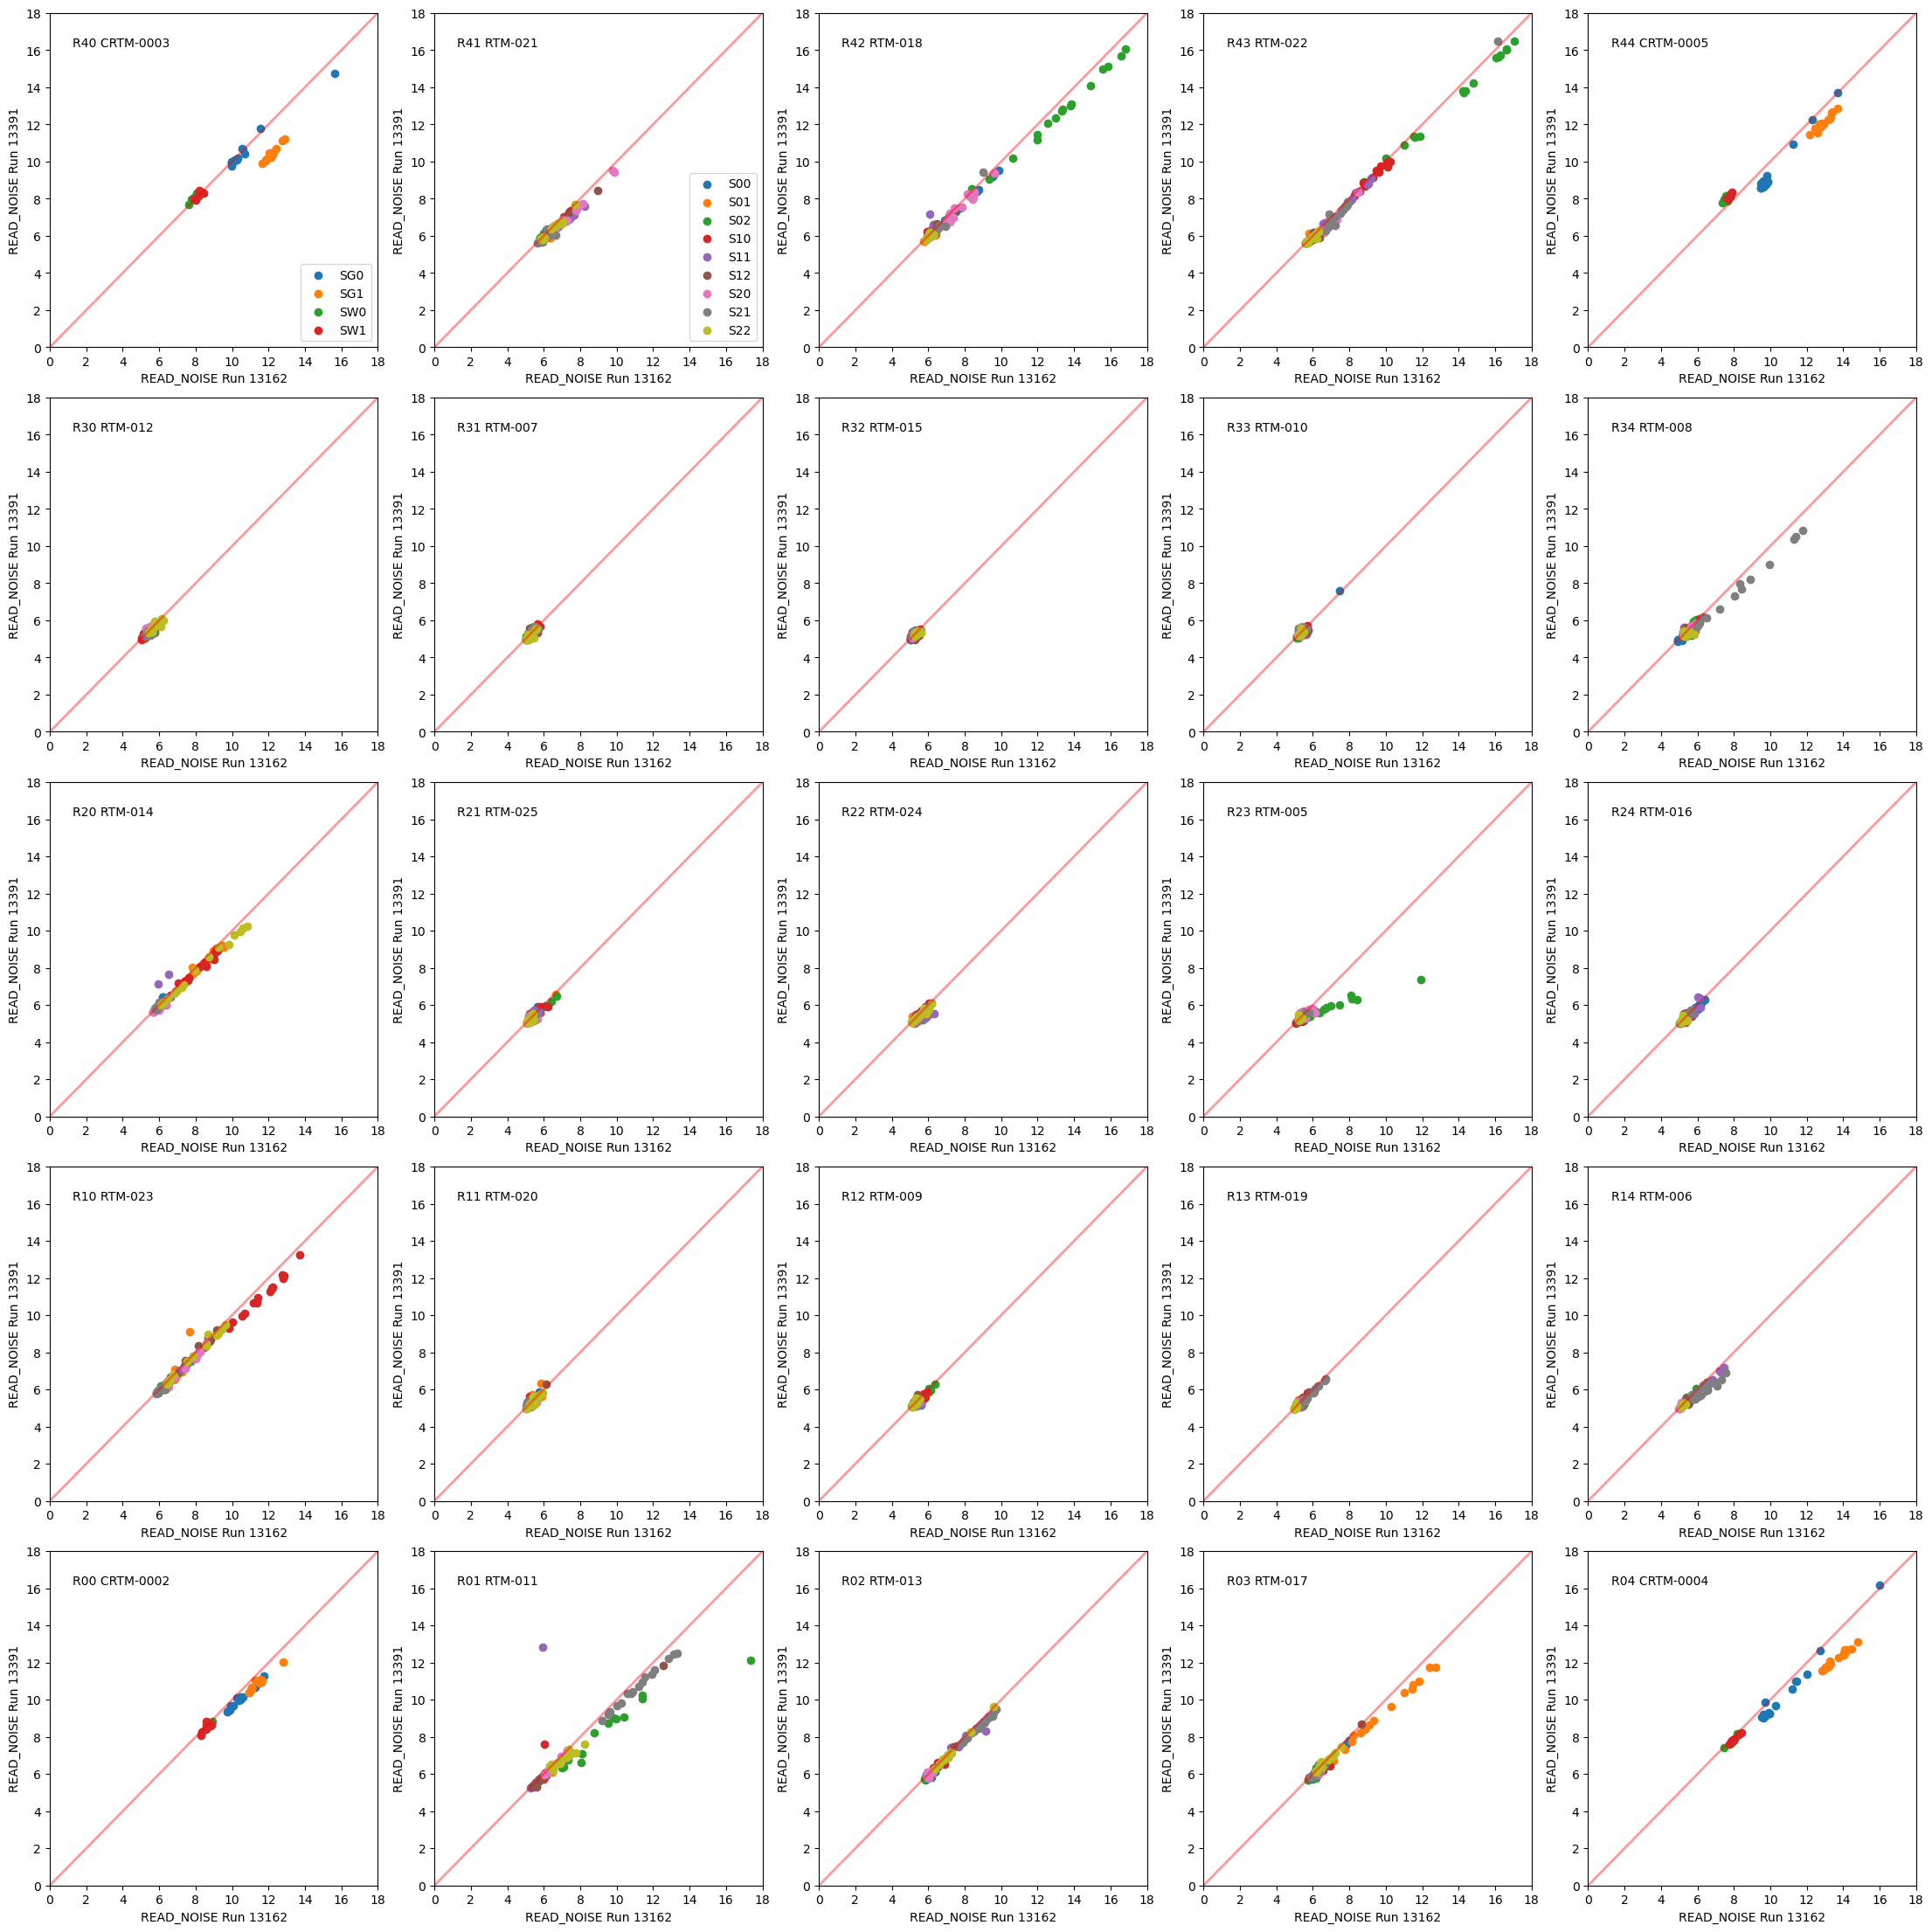

In [18]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='READ_NOISE',minxy=0.0,maxxy=18.0,save='read_noise_%s'%(acq_run))

## High Noise channels

In [19]:
highnoise = (df_merge.READ_NOISE>18.0)
print(tabulate(df_merge[highnoise][['BAY_SLOT','SEGMENT','READ_NOISE','PTC_GAIN','READ_NOISE_RUN5','PTC_GAIN_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE |   PTC_GAIN |   READ_NOISE_RUN5 |   PTC_GAIN_RUN5 | COMMENT                      |
|------+------------+-----------+--------------+------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |      43.3449 |  14.5068   |           6.17579 |        1.66522  | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |      33.5159 |  11.7085   |          42.1017  |       14.6135   | Dead Channel                 |
| 2704 | R40_SG1    | C10       |     210.592  |   2.4366   |         111.657   |        1.08202  | High Read Noise              |
| 3124 | R43_S20    | C14       |      82.9713 |   1.44755  |           7.43372 |        1.65021  | High Read Noise              |
| 3181 | R44_SG0    | C02       |      36.7336 |   0.973755 |          41       |  

In [20]:
lownoise = (df_merge.READ_NOISE<4.5)
print(tabulate(df_merge[lownoise][['BAY_SLOT','SEGMENT','READ_NOISE','READ_NOISE_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+-----+------------+-----------+--------------+-------------------+--------------+
|     | BAY_SLOT   | SEGMENT   |   READ_NOISE |   READ_NOISE_RUN5 | COMMENT      |
|-----+------------+-----------+--------------+-------------------+--------------|
| 481 | R04_SG0    | C11       |     0.499504 |               nan | Dead Channel |
+-----+------------+-----------+--------------+-------------------+--------------+


# PTC Gain

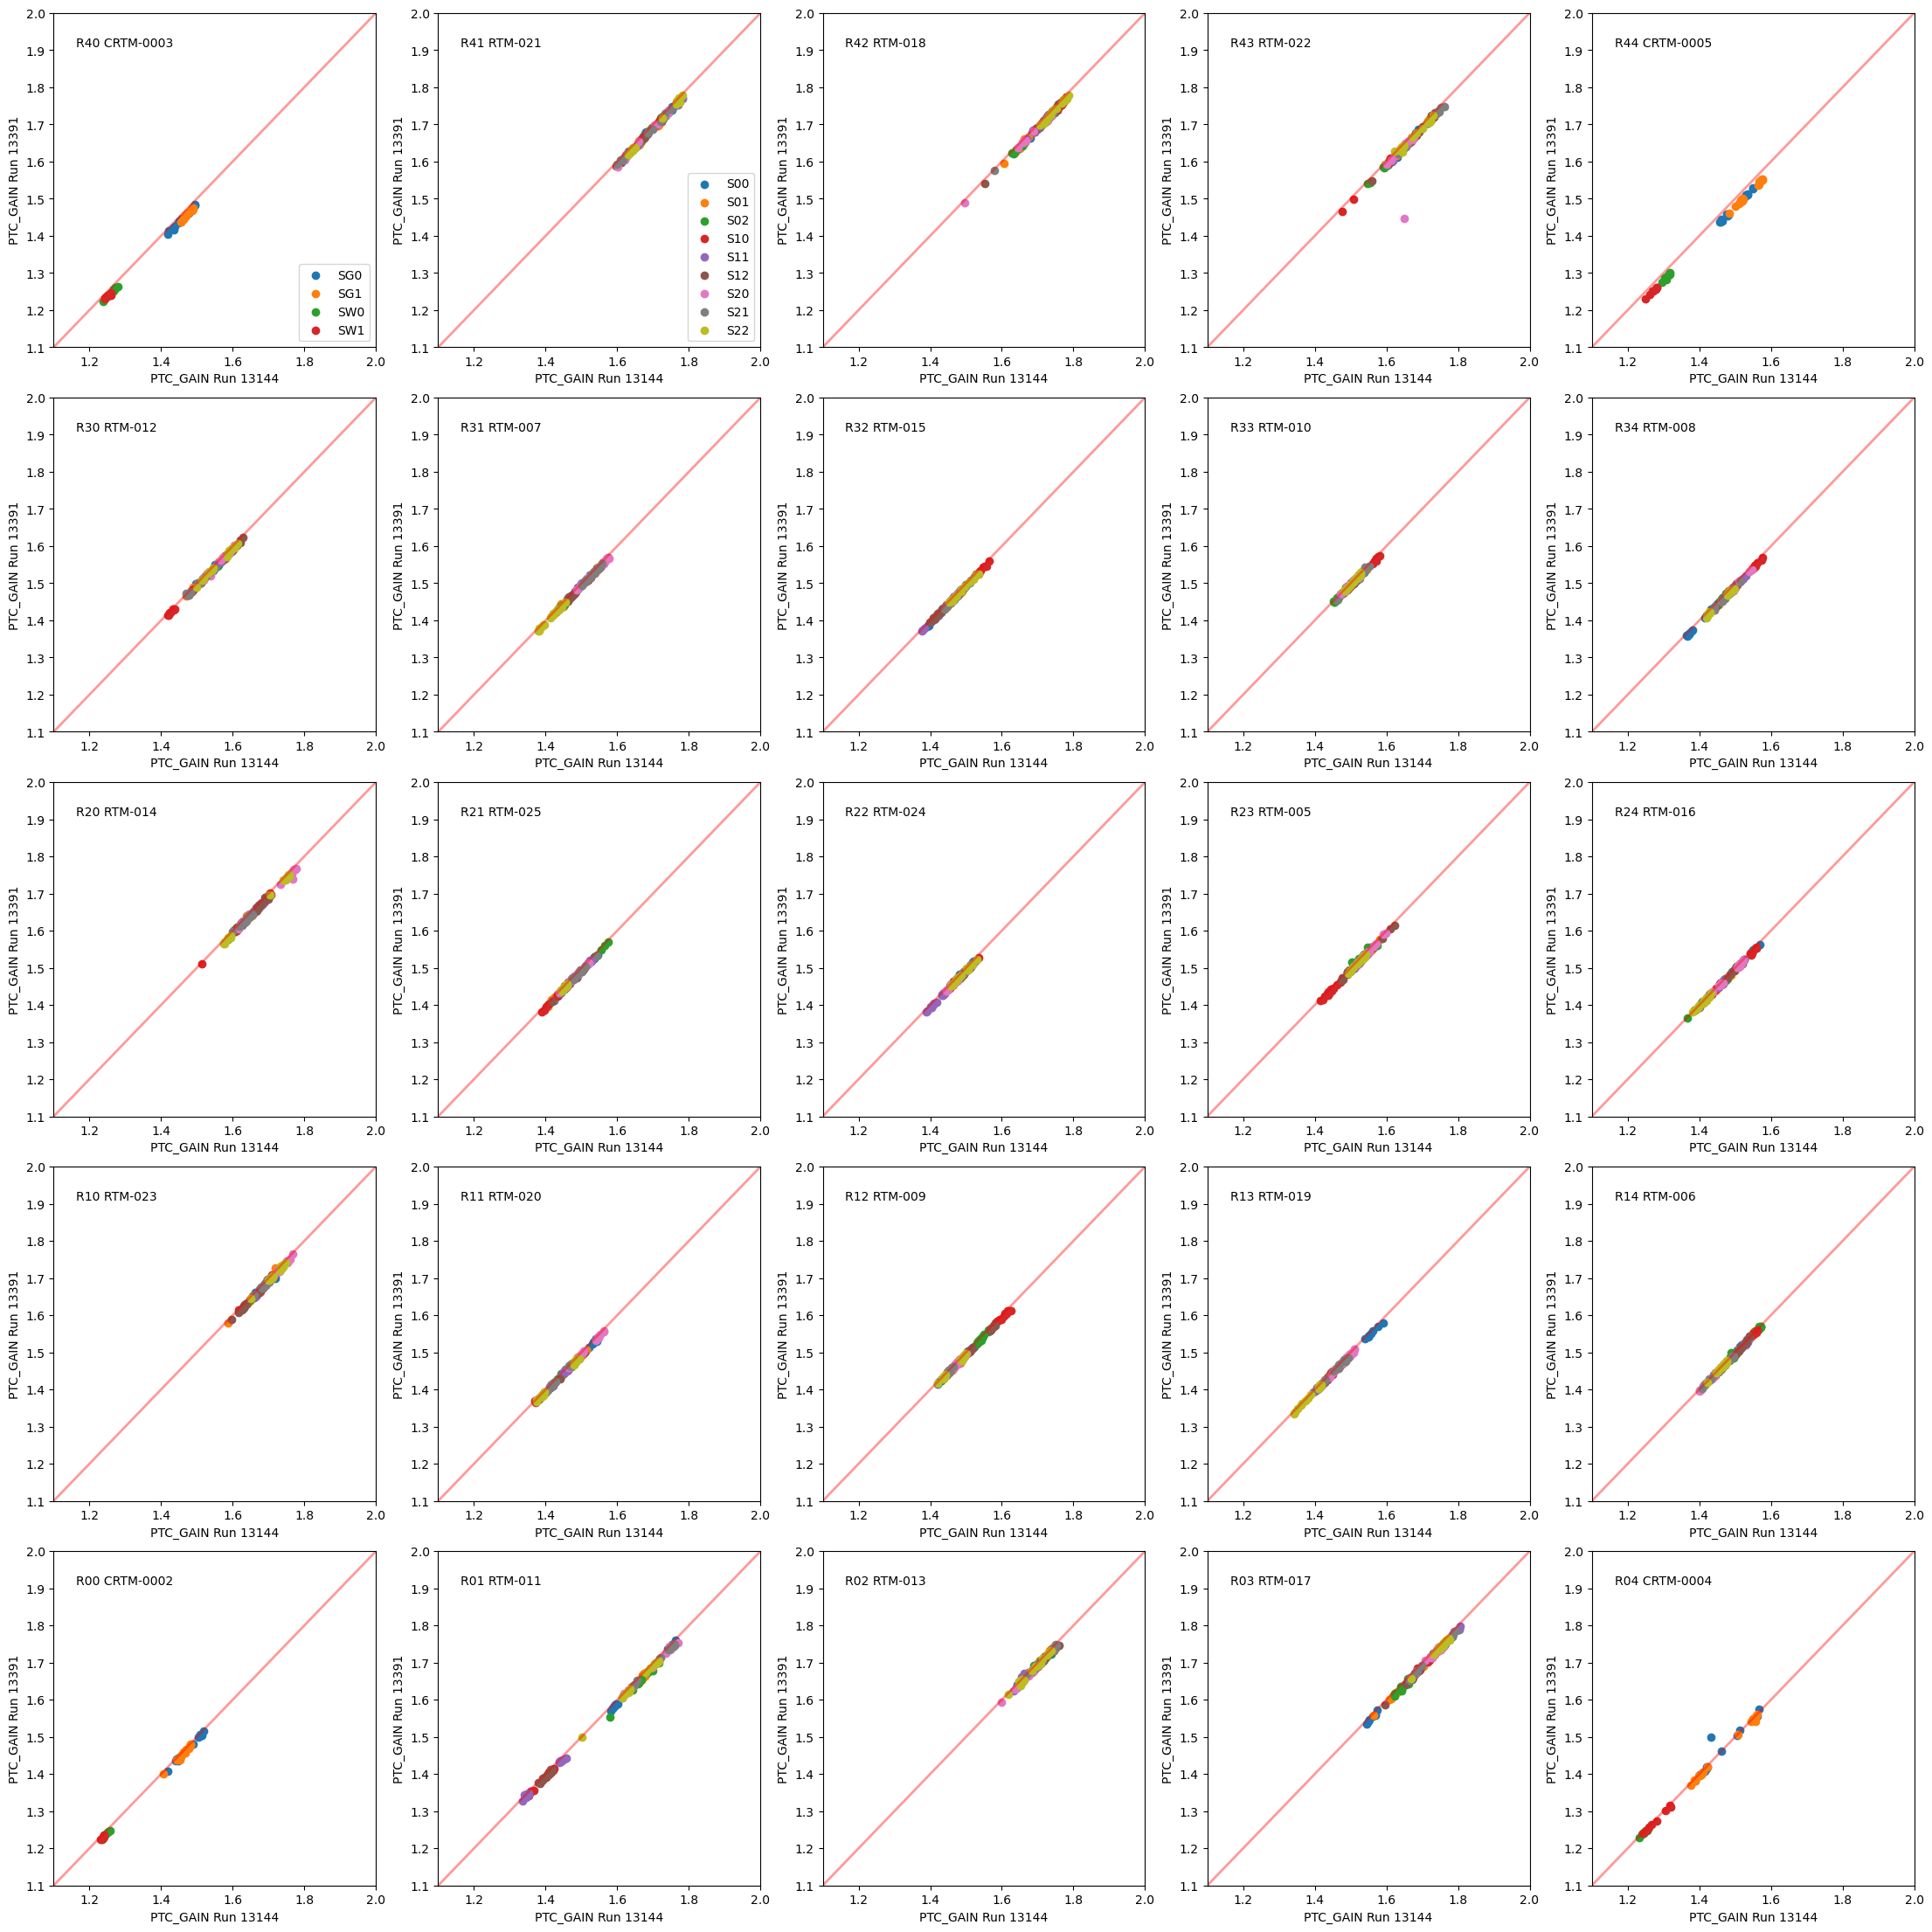

In [21]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='PTC_GAIN',minxy=1.1,maxxy=2.0,save='ptc_gain_%s.png'%(acq_run))

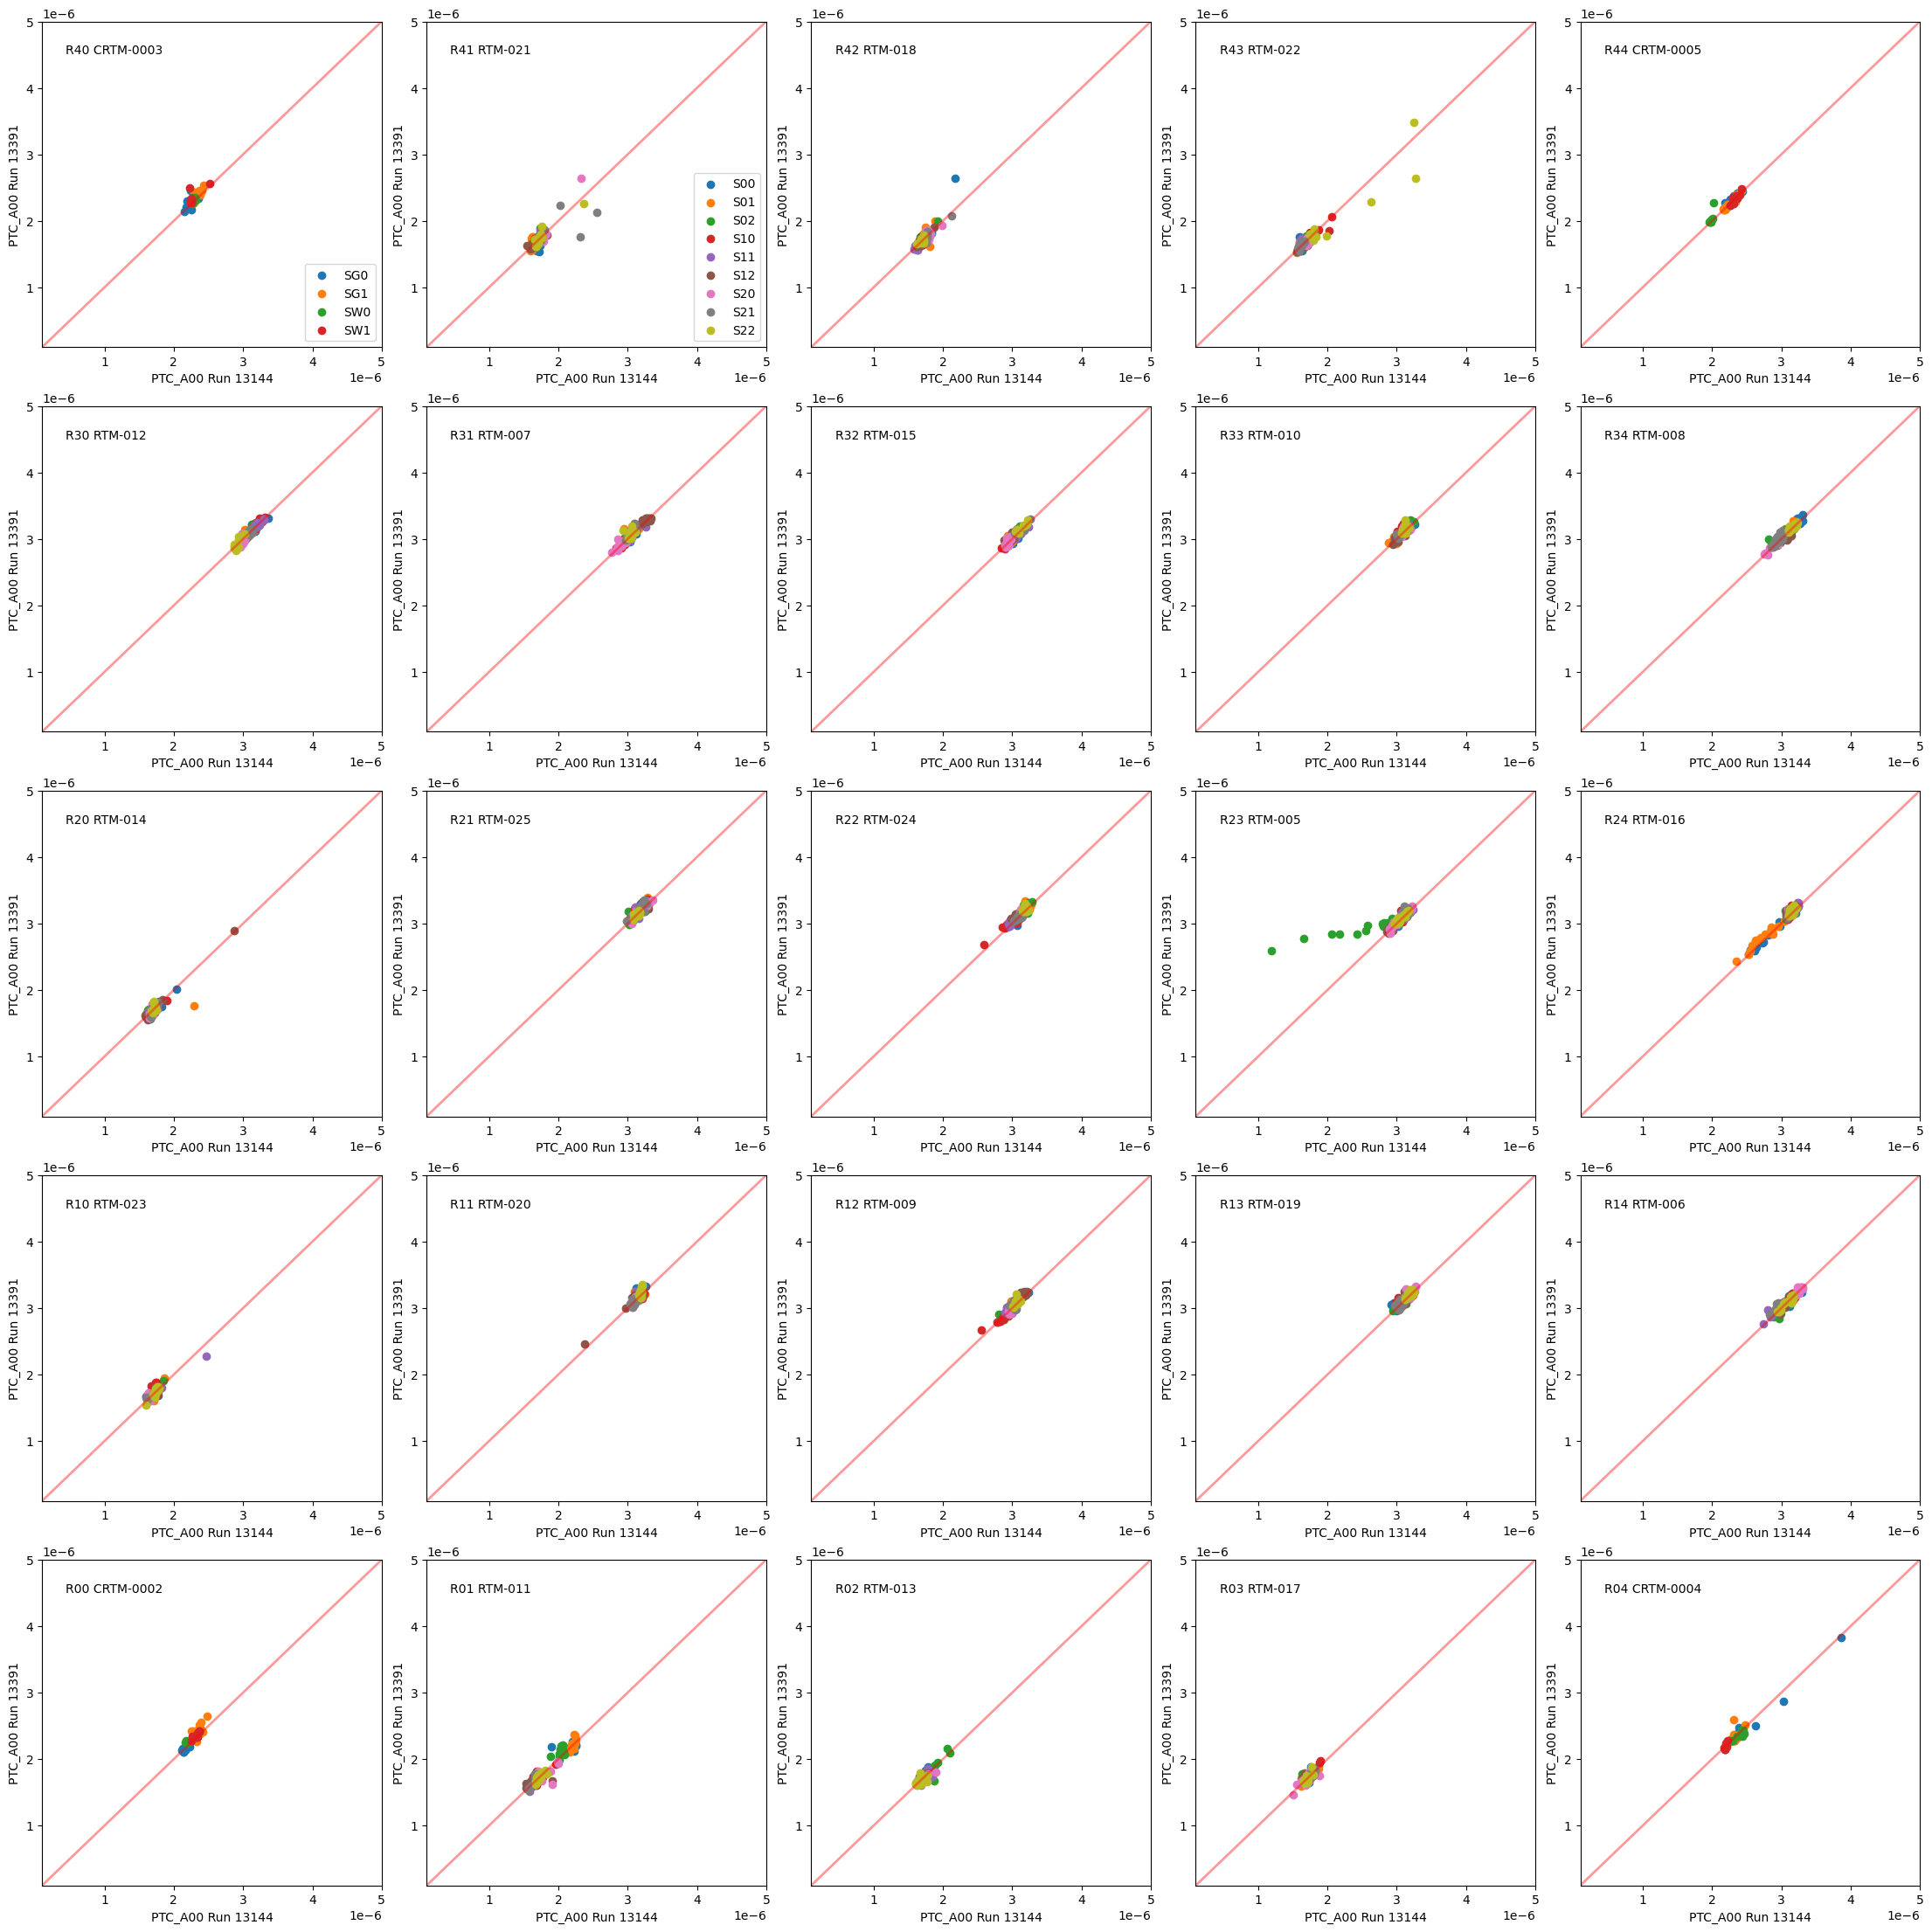

In [86]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='PTC_A00',minxy=1.e-7,maxxy=0.5e-5,save='ptc_a00_%s.png'%(acq_run))

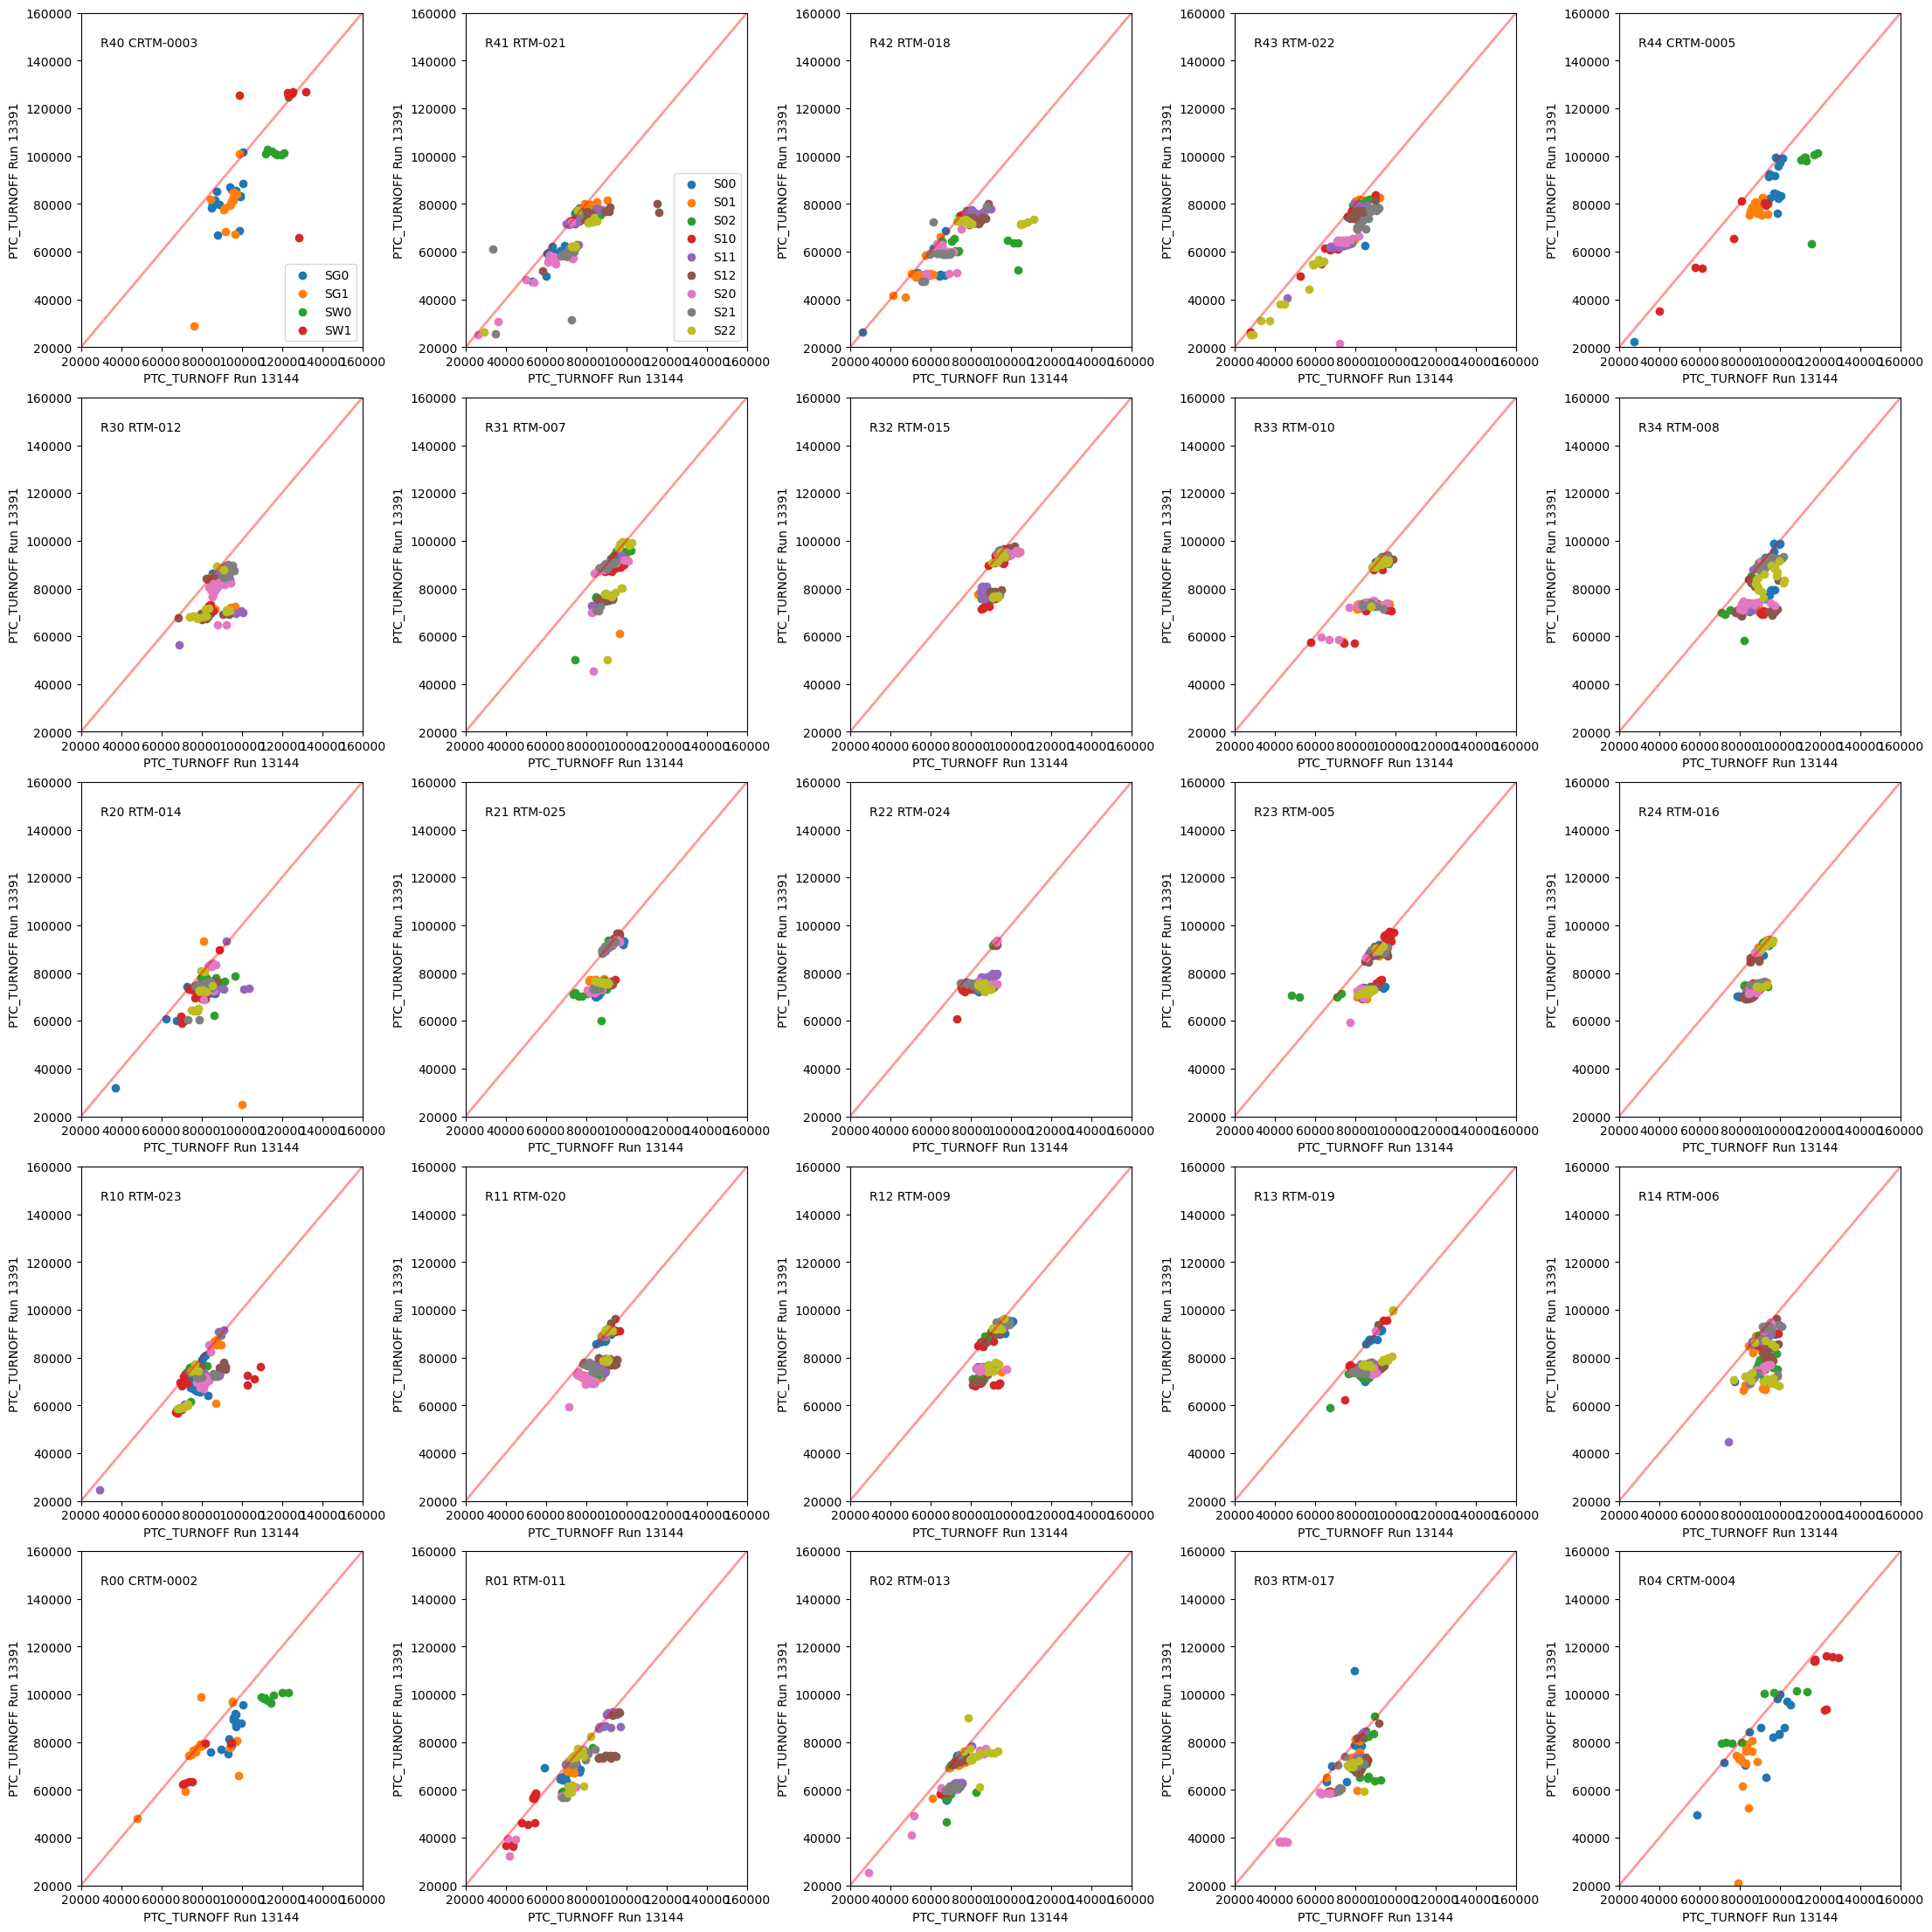

In [88]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='PTC_TURNOFF',minxy=2.0e4,maxxy=1.6e5,save='ptc_turnoff_%s.png'%(acq_run))

In [23]:
badgain1 = (df_merge.PTC_GAIN>2.0) | (df_merge.PTC_GAIN<1.2) | (np.isnan(df_merge.PTC_GAIN))
highnoise1 = (df_merge.READ_NOISE>18.0)

badgain2 = (df_merge.PTC_GAIN_RUN5>2.0) | (df_merge.PTC_GAIN_RUN5<1.2) | (np.isnan(df_merge.PTC_GAIN_RUN5))
highnoise2 = (df_merge.READ_NOISE_RUN5>18.0)

print(tabulate(df_merge[badgain][['BAY_SLOT','SEGMENT','READ_NOISE','PTC_GAIN','READ_NOISE_RUN5','PTC_GAIN_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+--------------+-------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE |    PTC_GAIN |   READ_NOISE_RUN5 |   PTC_GAIN_RUN5 | COMMENT                      |
|------+------------+-----------+--------------+-------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |    43.3449   |  14.5068    |           6.17579 |        1.66522  | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |    33.5159   |  11.7085    |          42.1017  |       14.6135   | Dead Channel                 |
|  481 | R04_SG0    | C11       |     0.499504 |   0.0407857 |         nan       |      nan        | Dead Channel                 |
| 1968 | R30_S00    | C10       |   nan        | nan         |         nan       |      nan        | Dead Channel                 |
| 2704 | R40_SG1    | C10       |   210.592    |   2.4366    |         111.6

# Linearity

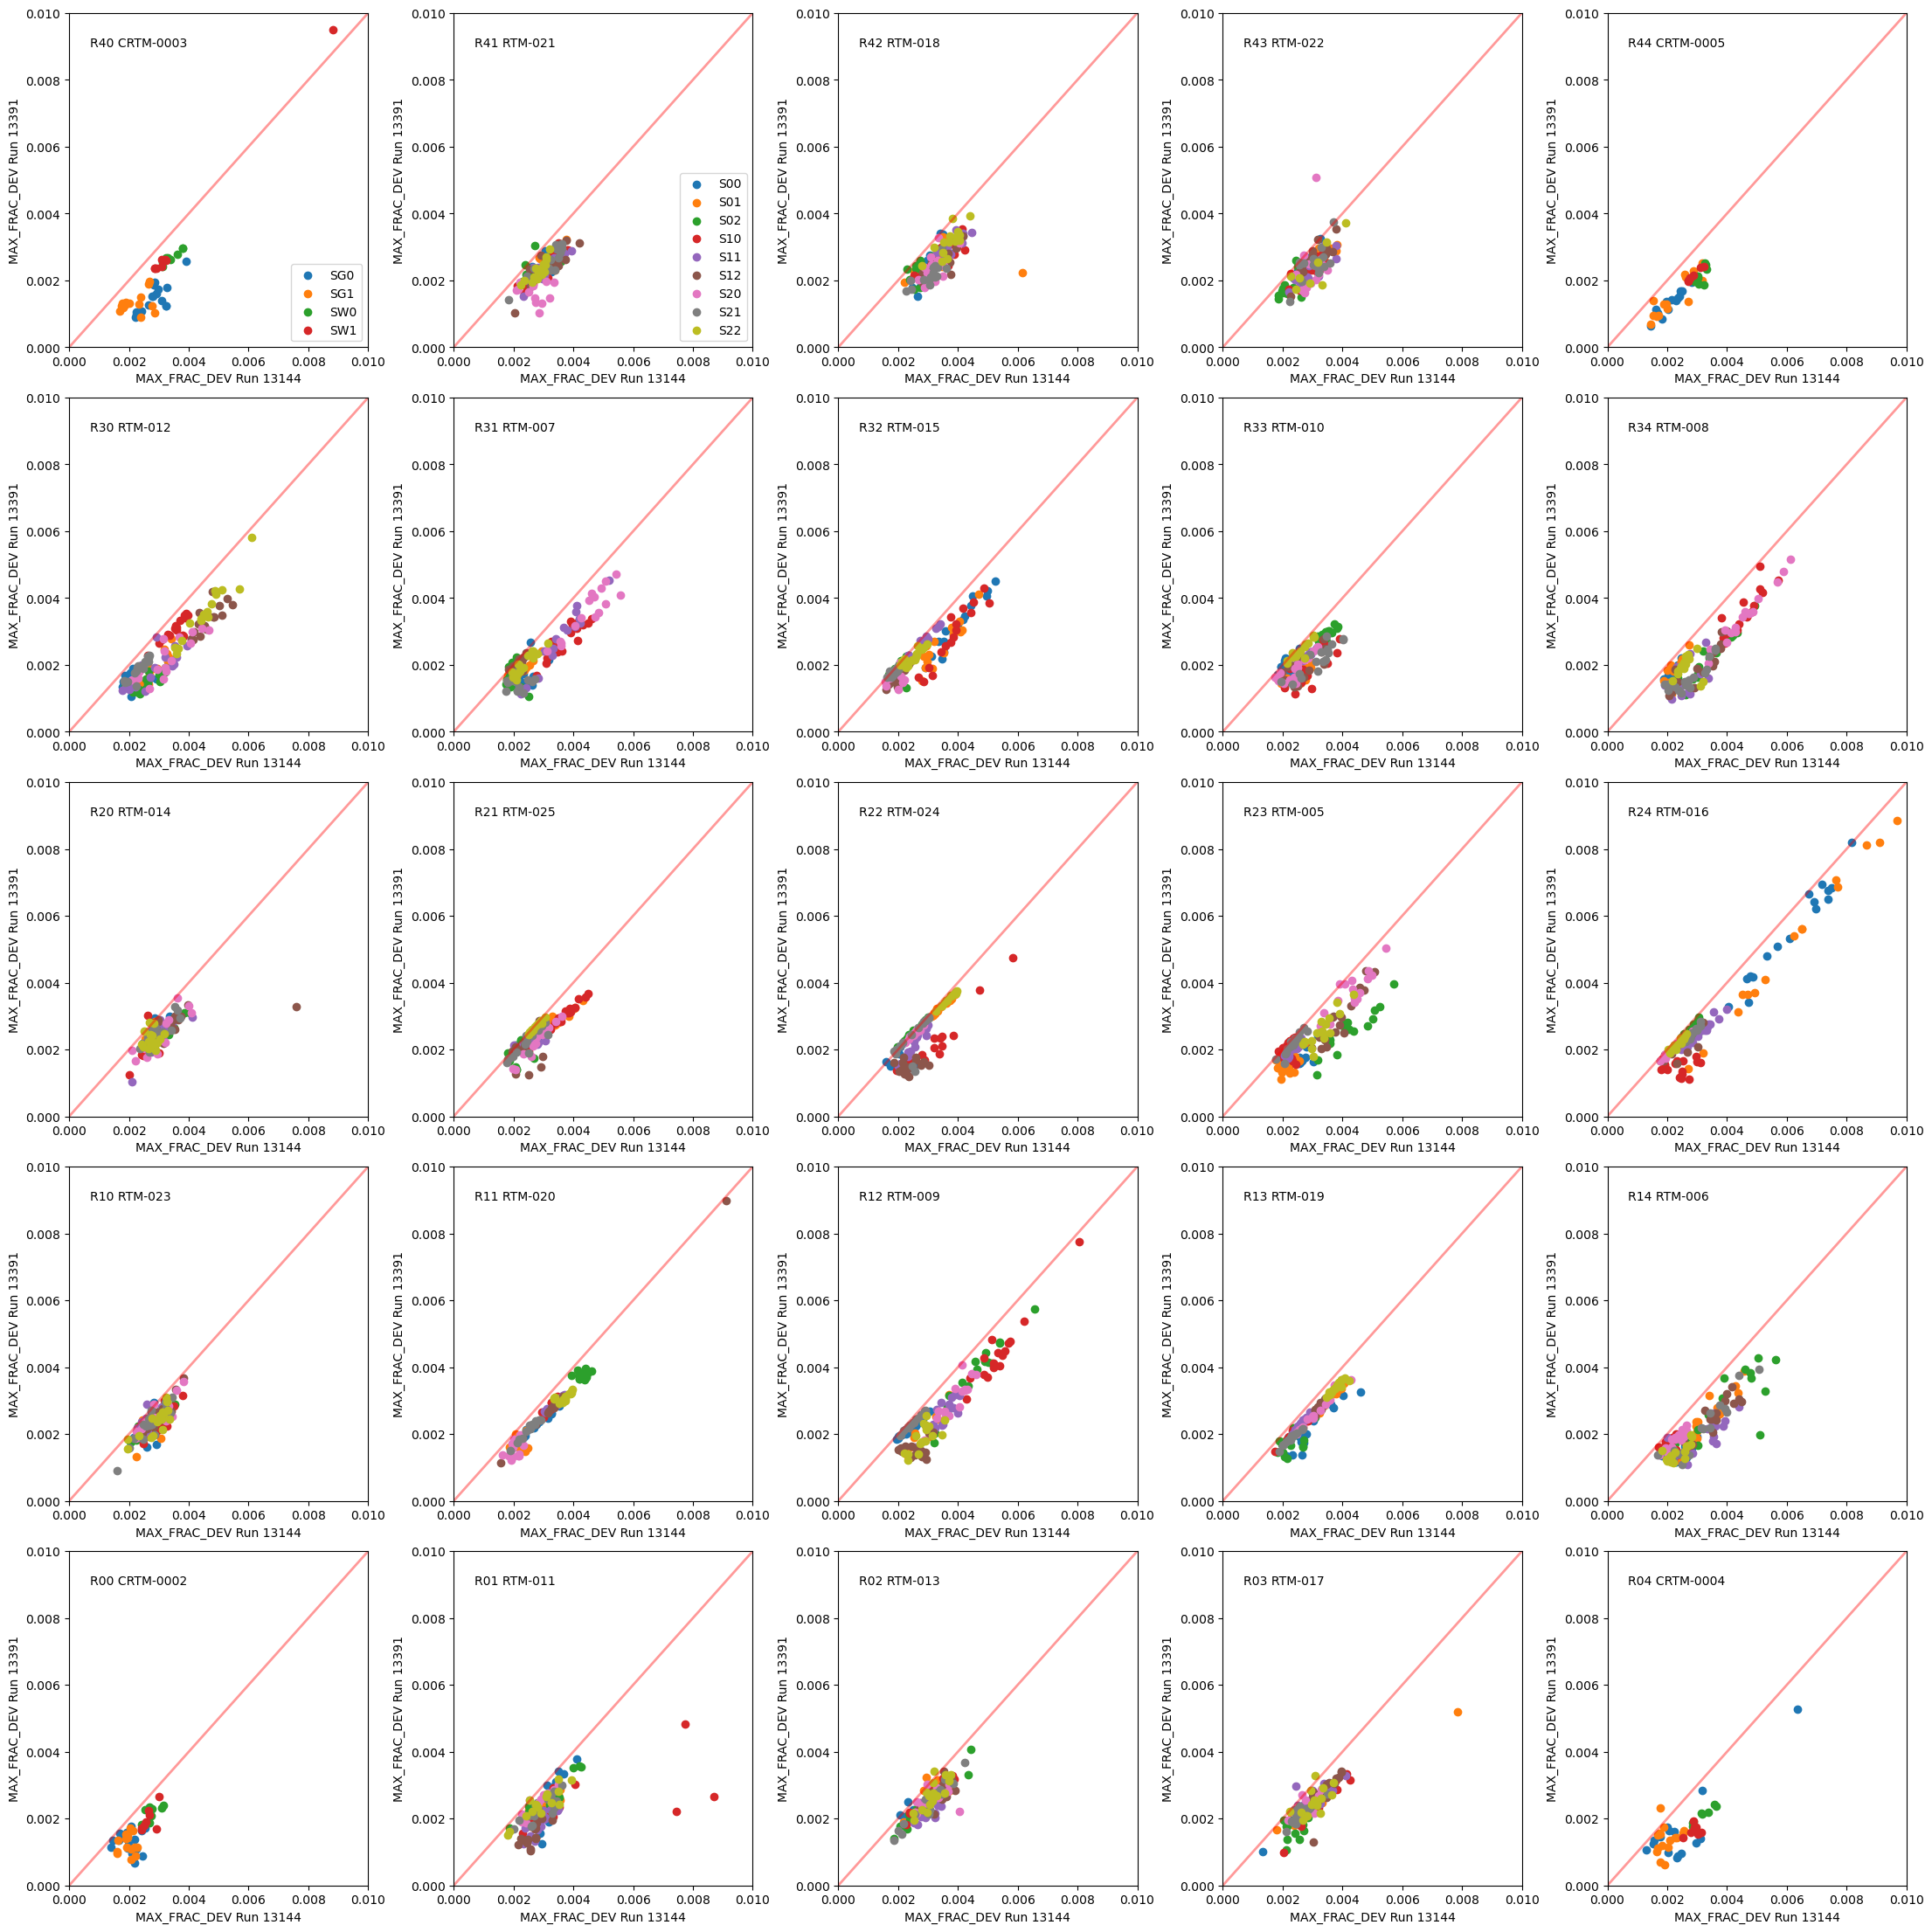

In [100]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='MAX_FRAC_DEV',minxy=0.0,maxxy=0.01,save='maxfracdev_%s.png'%(acq_run))

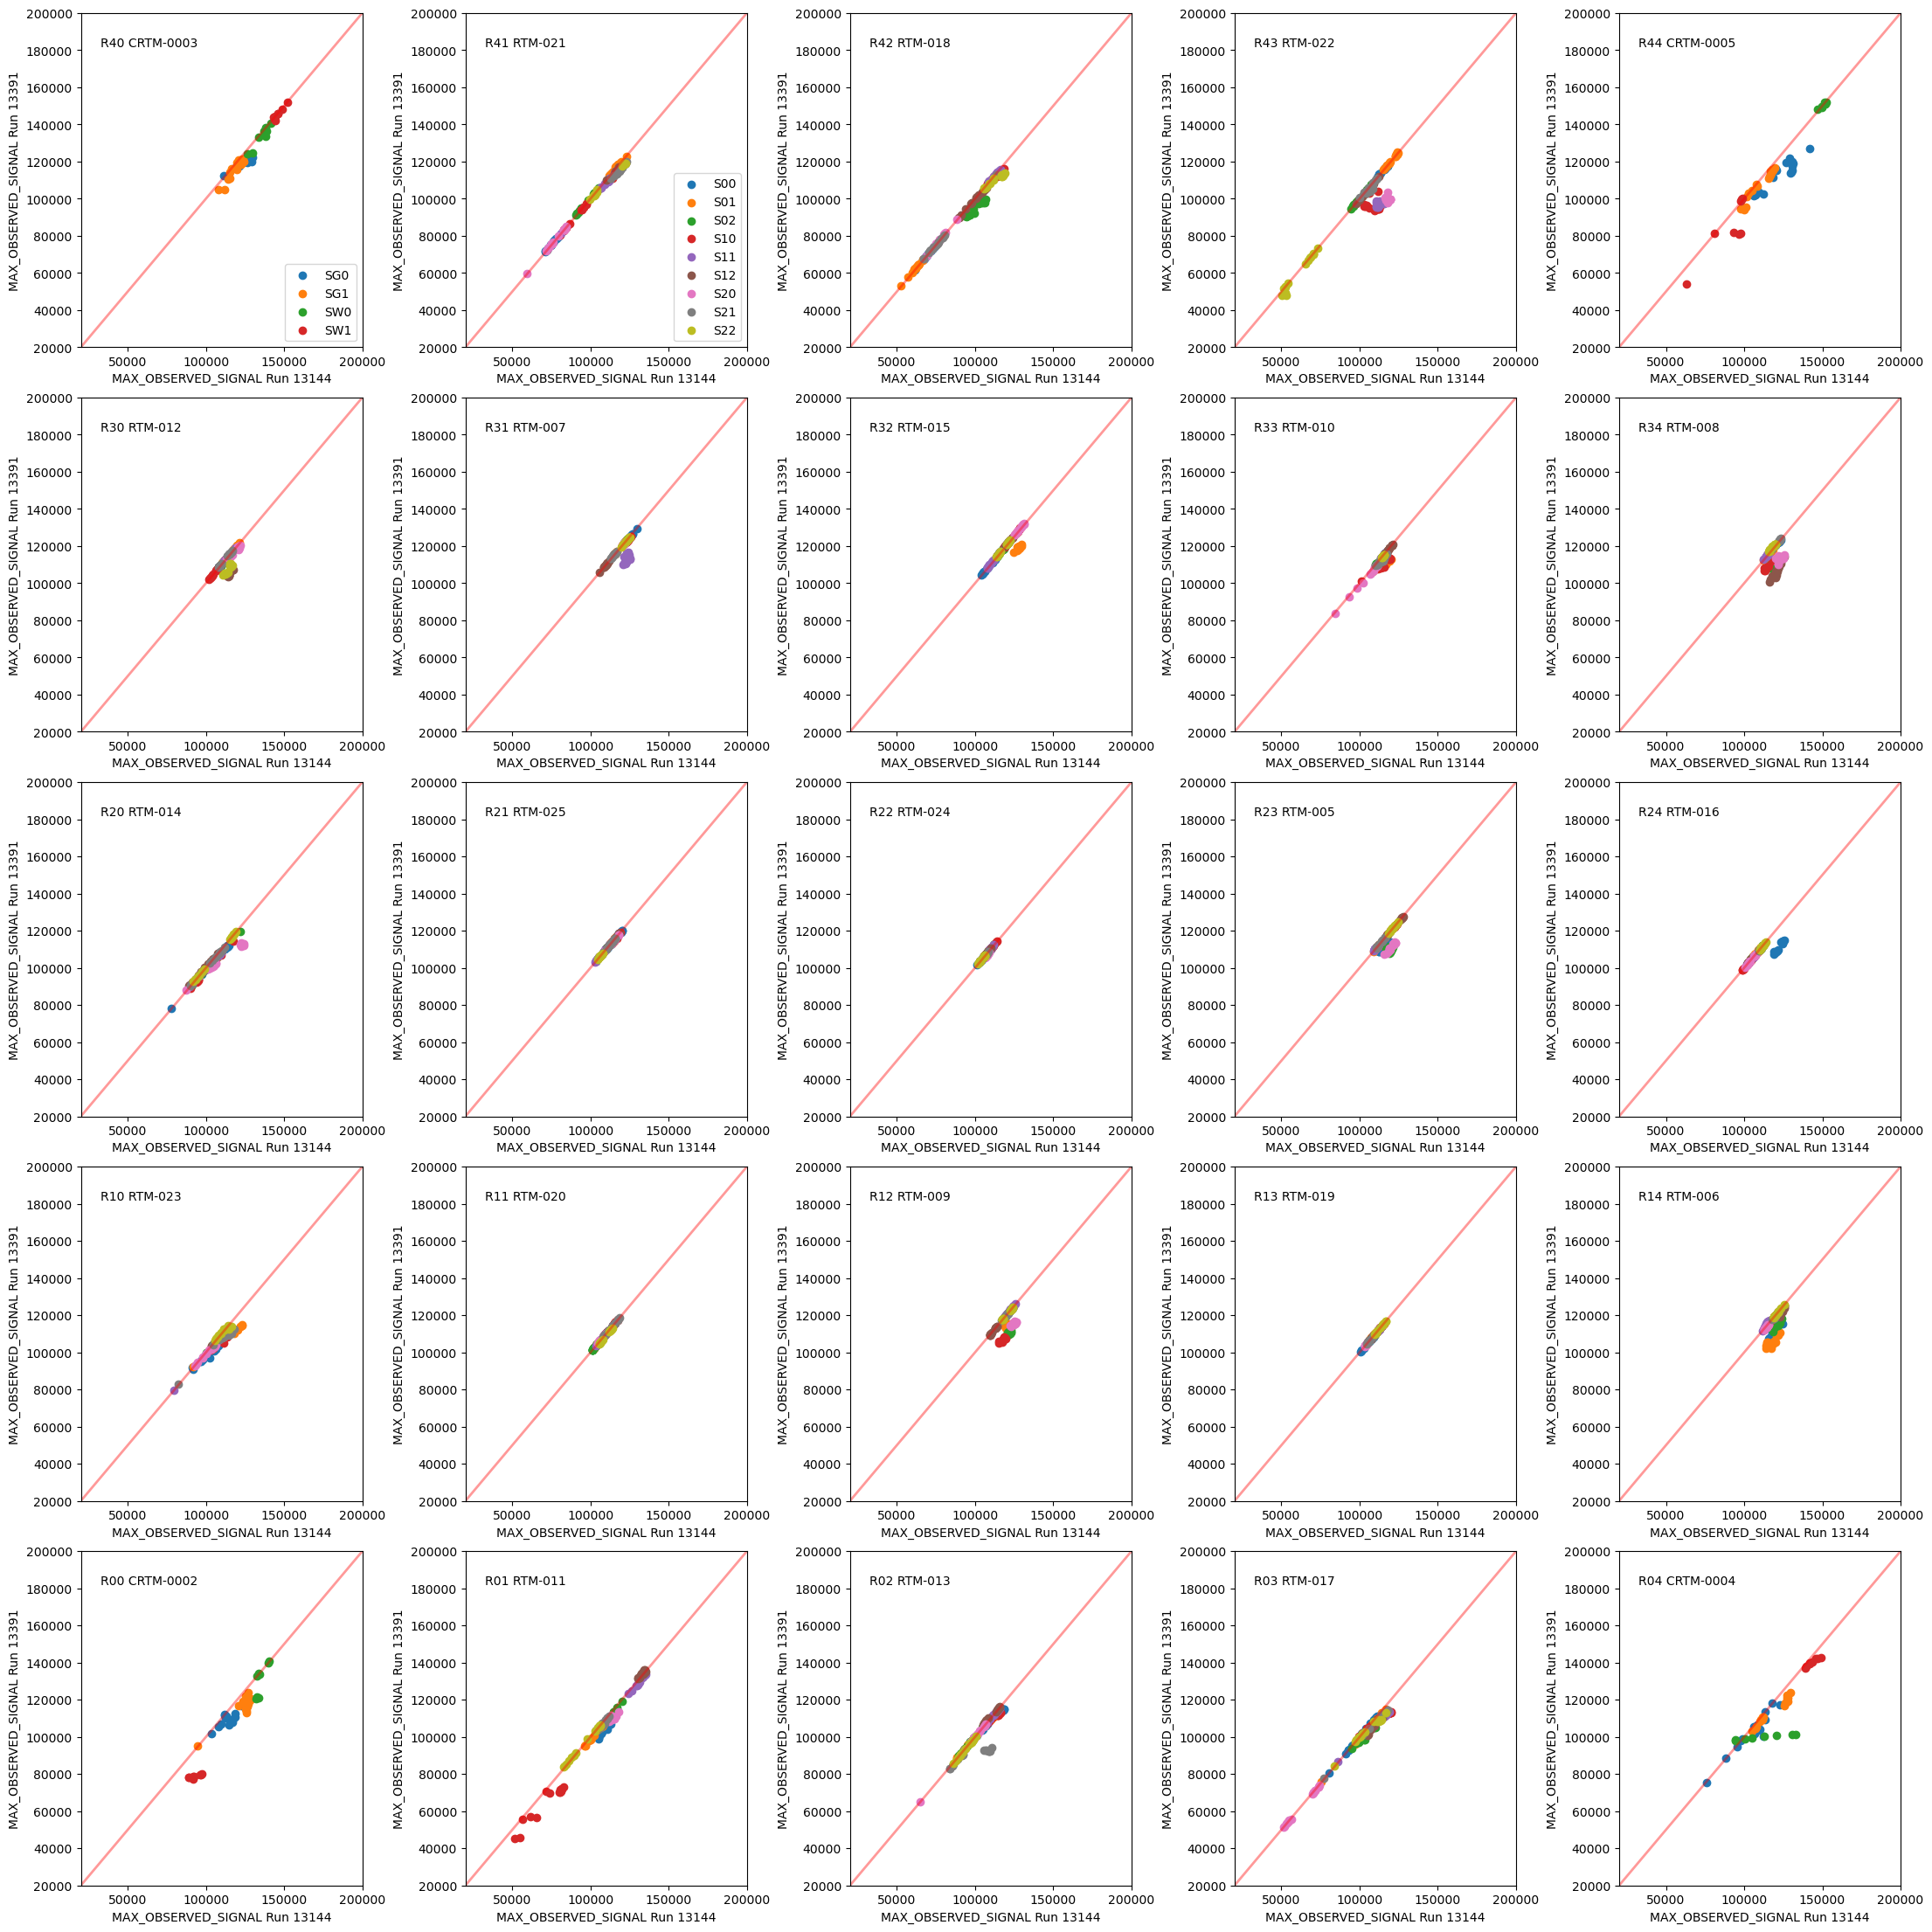

In [102]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='MAX_OBSERVED_SIGNAL',minxy=2.0e4,maxxy=2.0e5,save='maxobssignal_%s.png'%(acq_run))

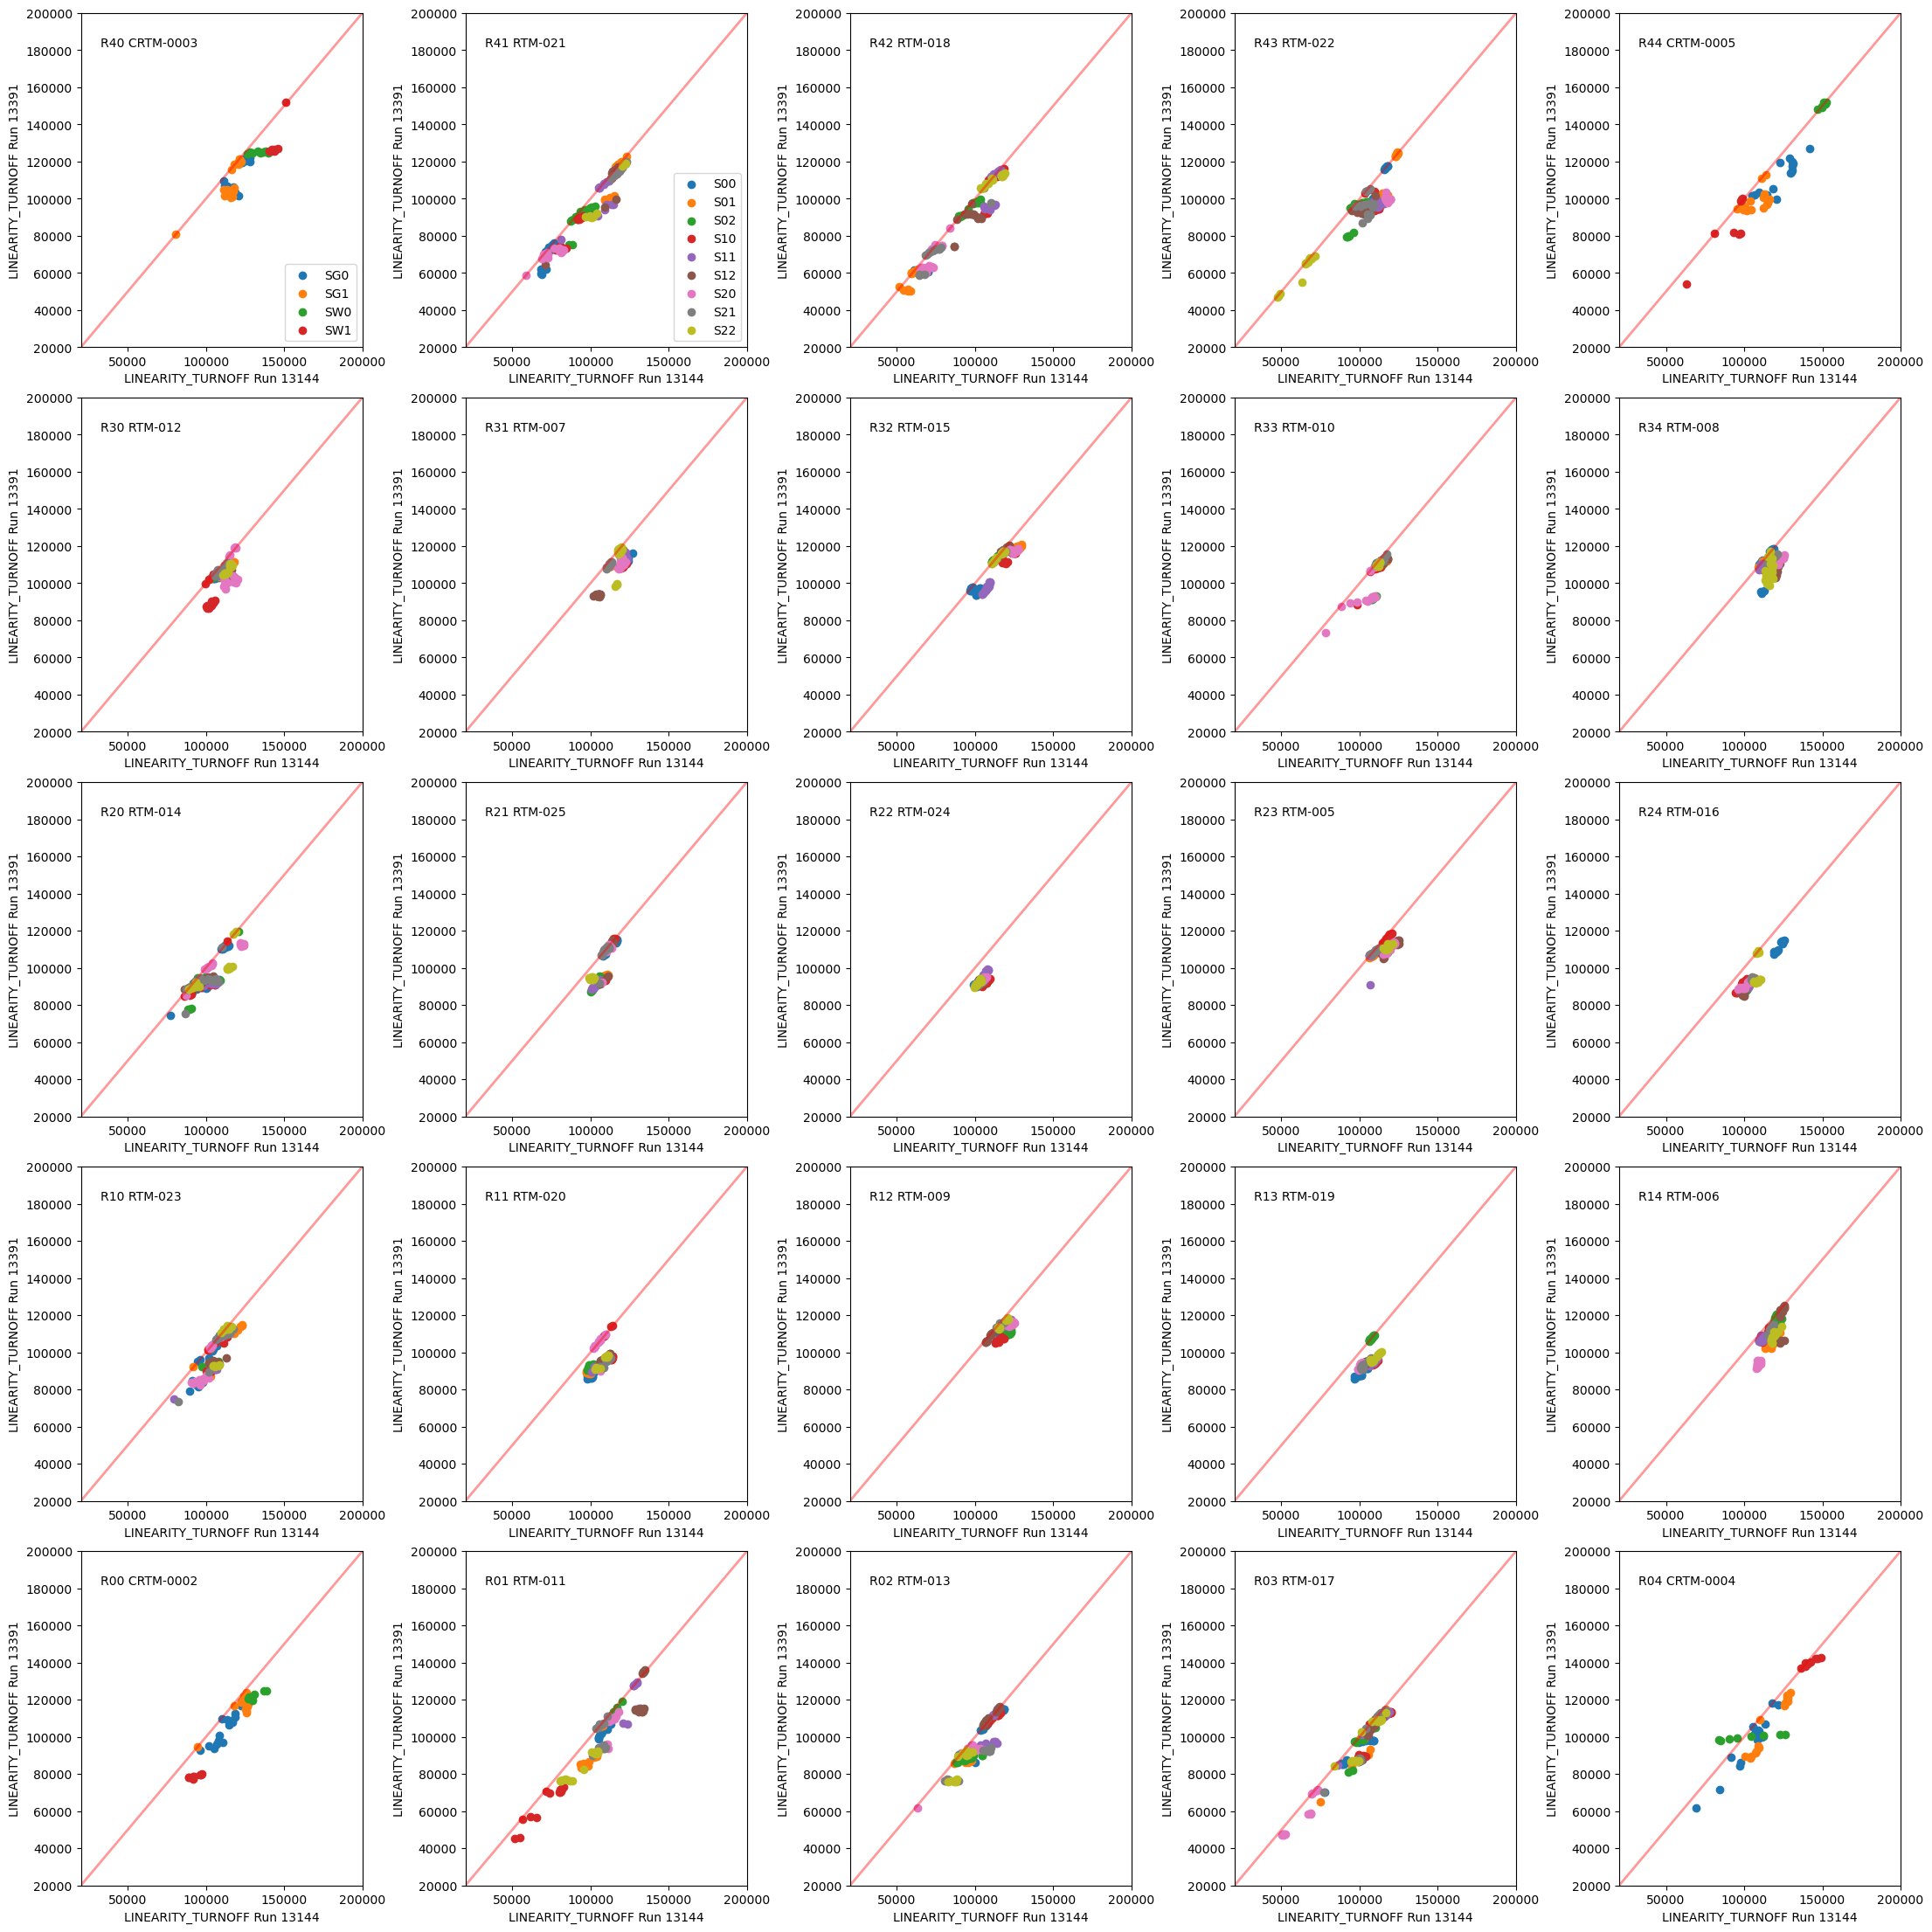

In [103]:
compare_tworuns(df_run5,df_data,'13144',acq_run,quantity='LINEARITY_TURNOFF',minxy=2.0e4,maxxy=2.0e5,save='linearity_turnoff_%s.png'%(acq_run))

# CTI Serial and Parallel

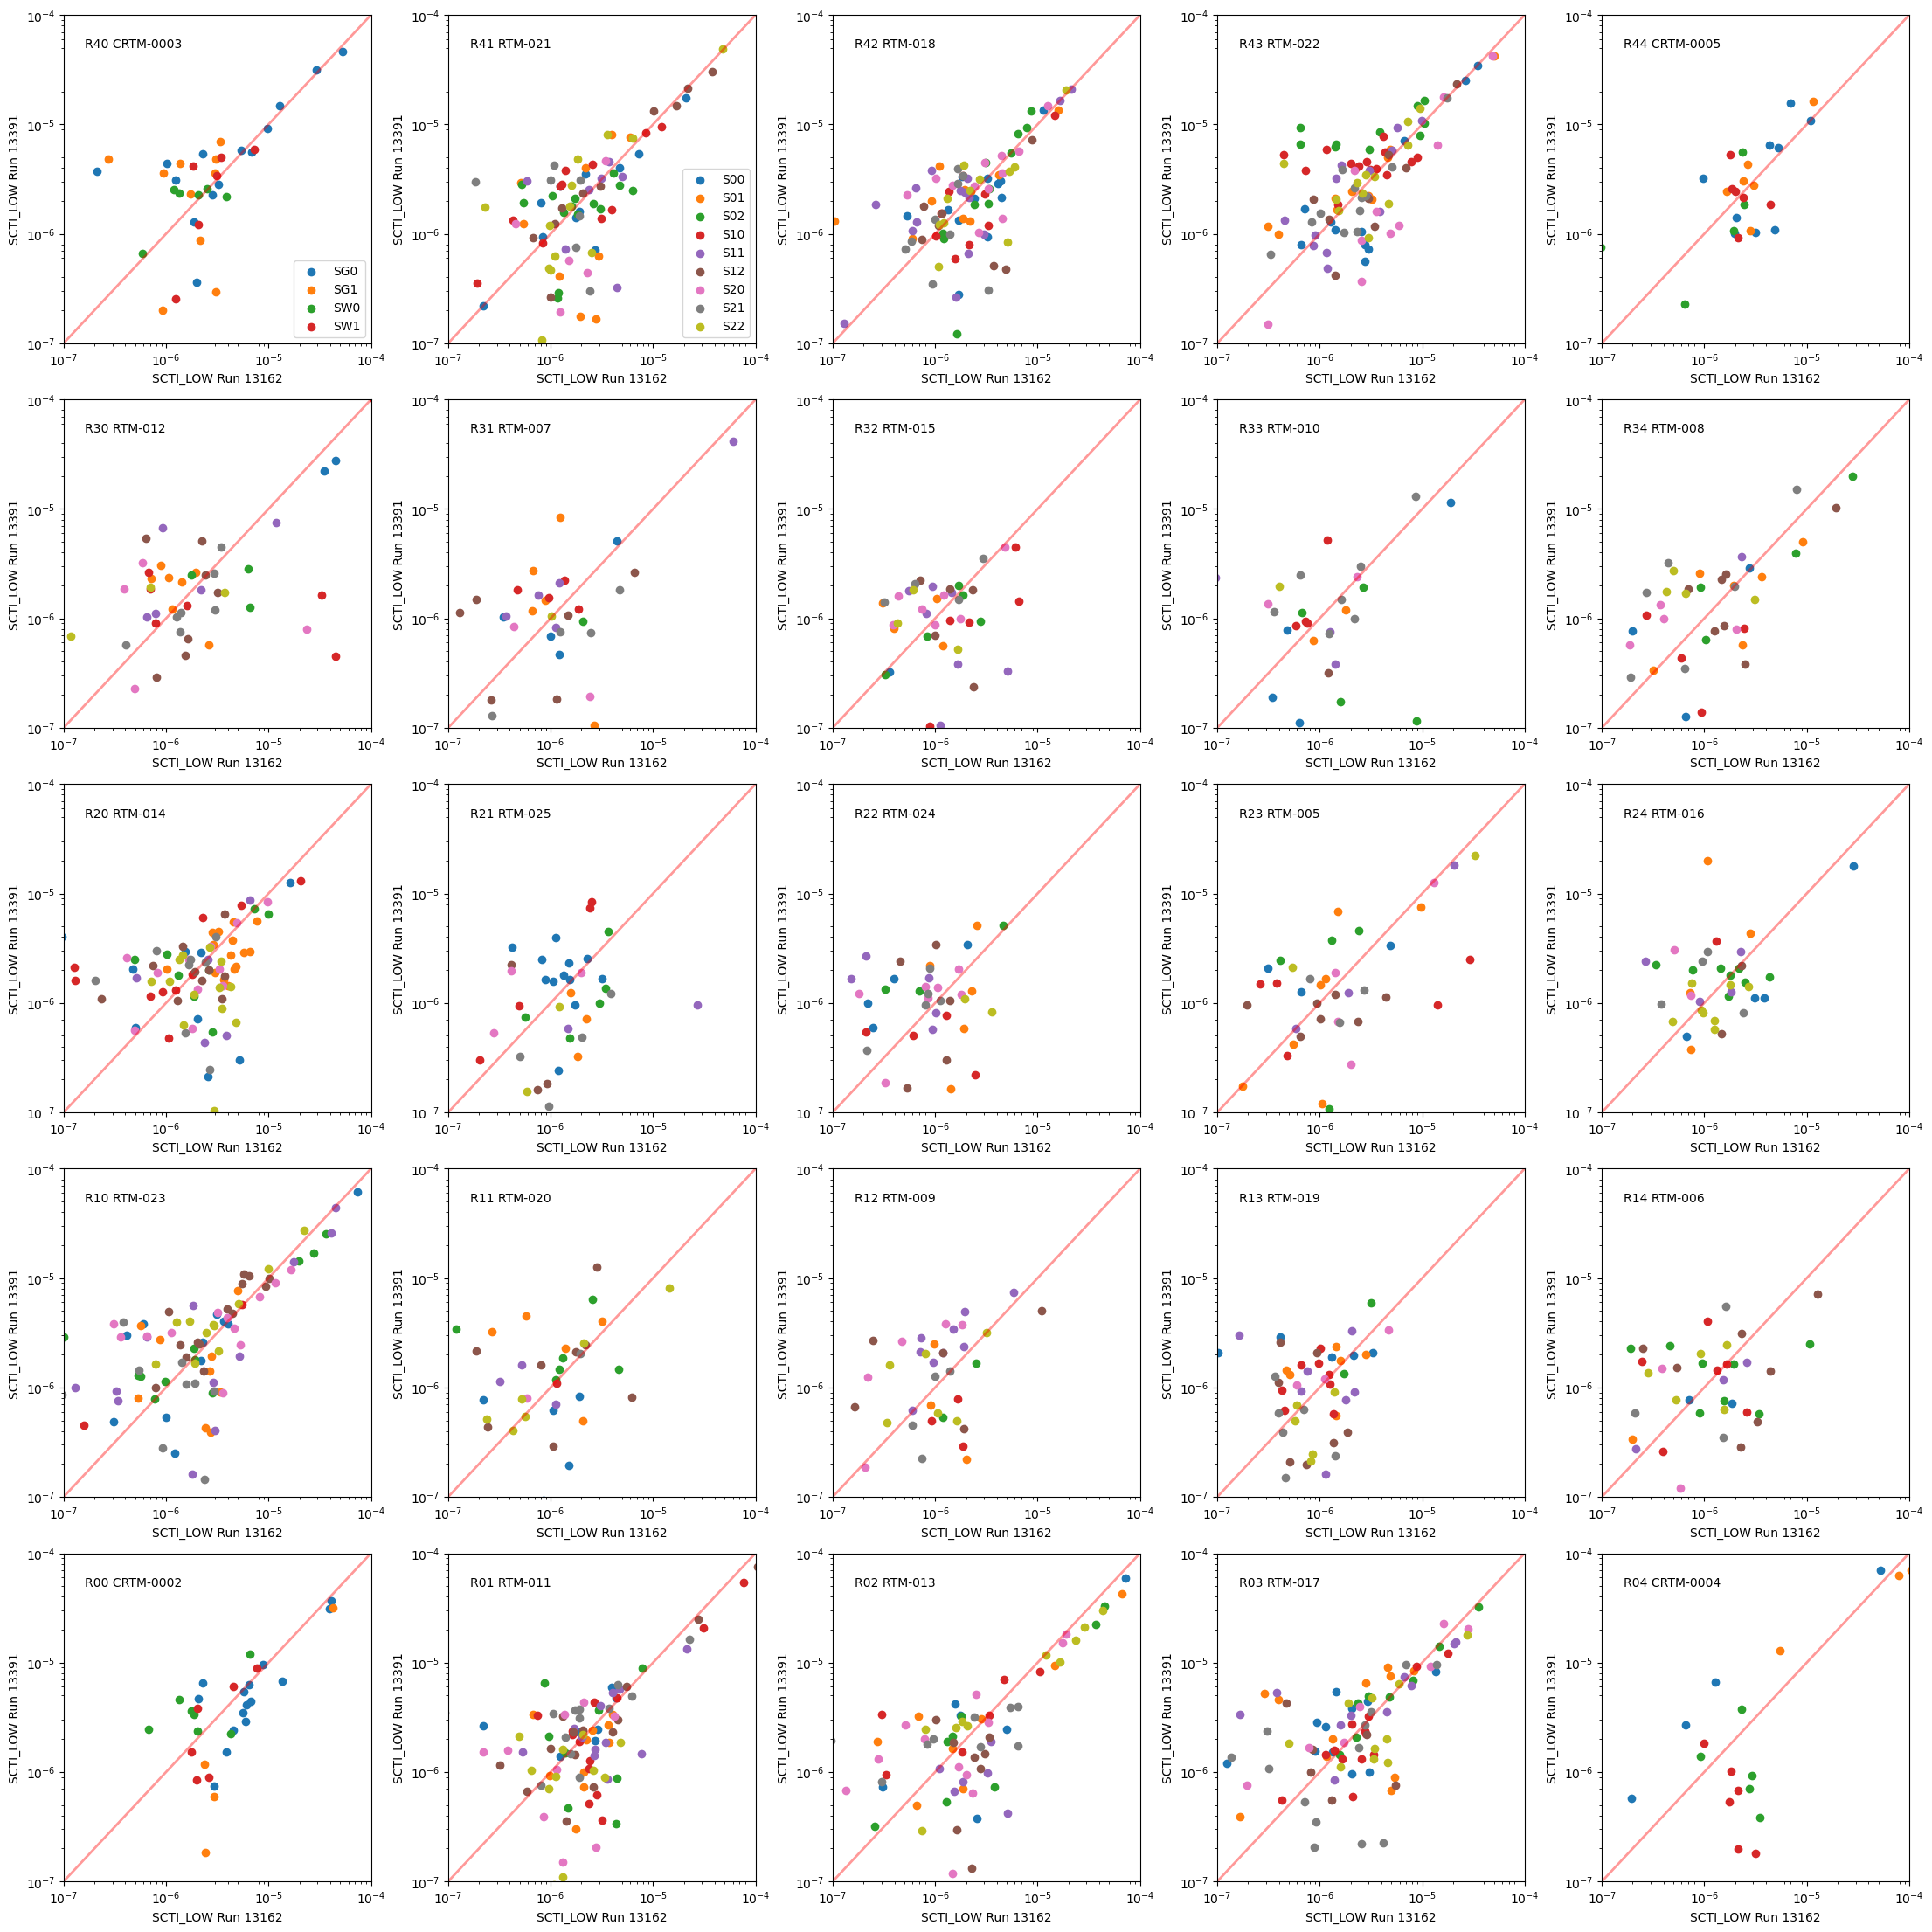

In [24]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='SCTI_LOW',minxy=1.e-7,maxxy=1.e-4,scale='log',save='scti_low_%s'%(acq_run))

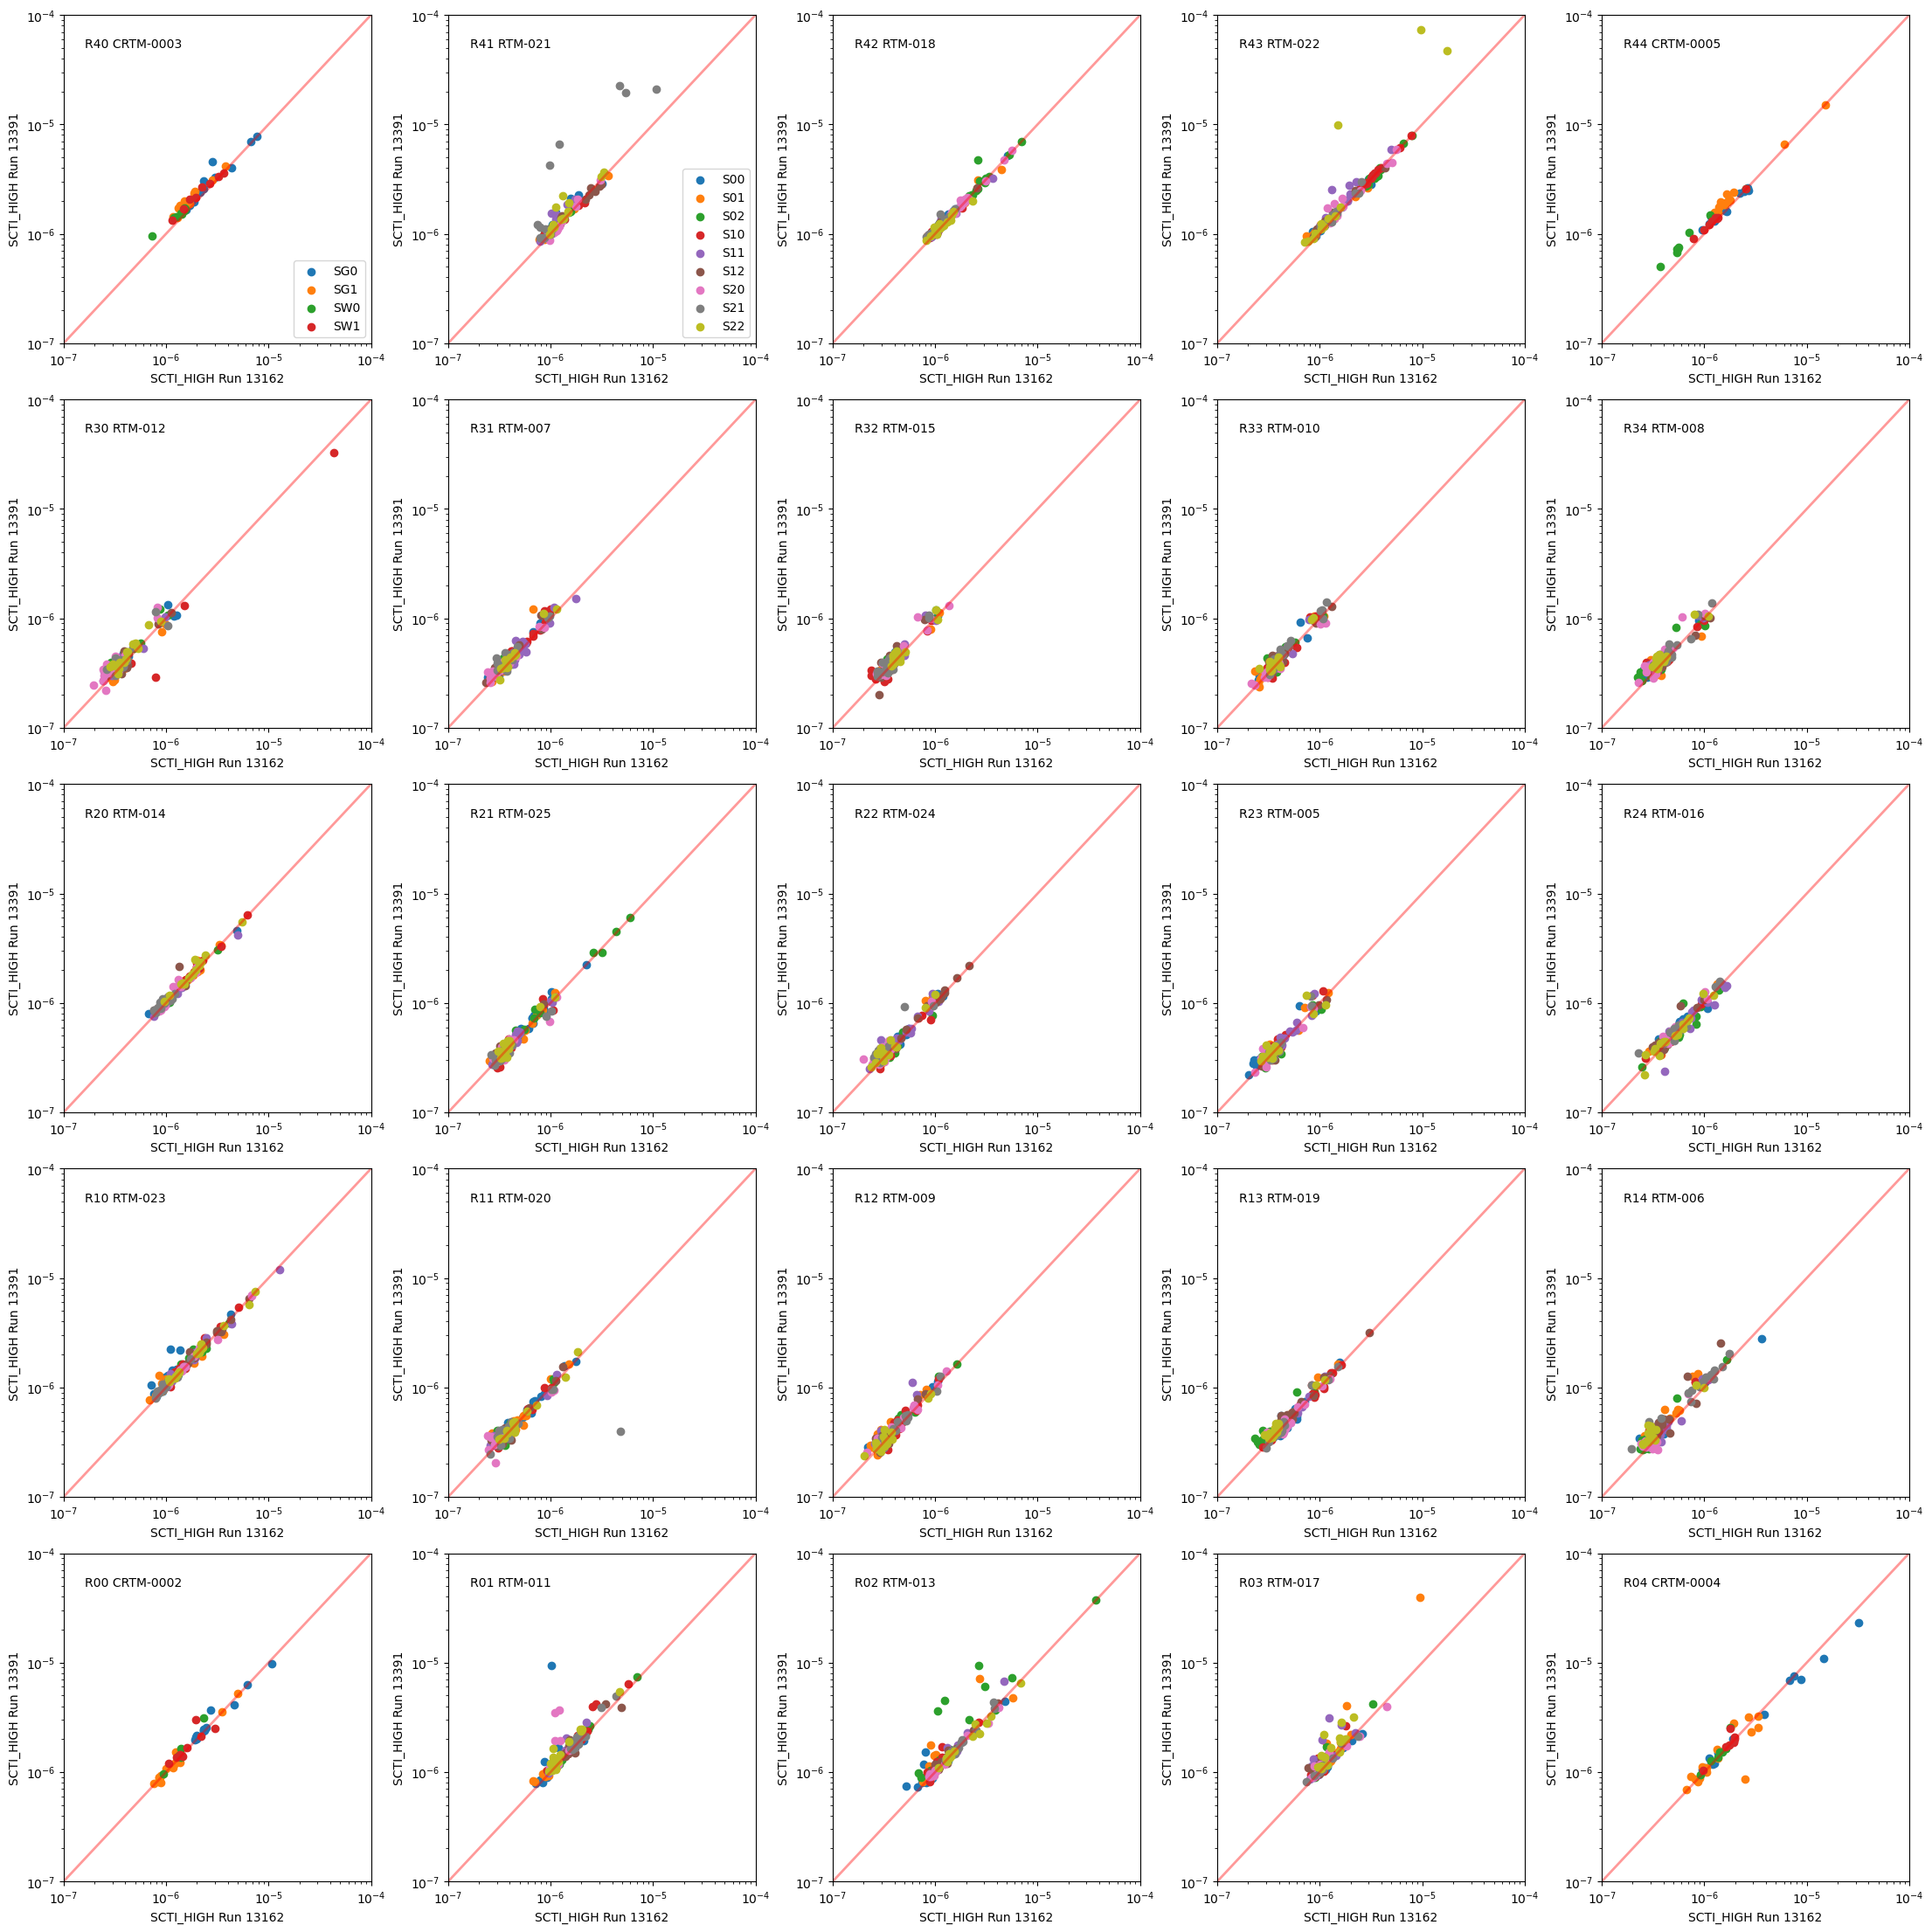

In [25]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='SCTI_HIGH',minxy=1.e-7,maxxy=1.e-4,scale='log',save='scti_high_%s'%(acq_run))

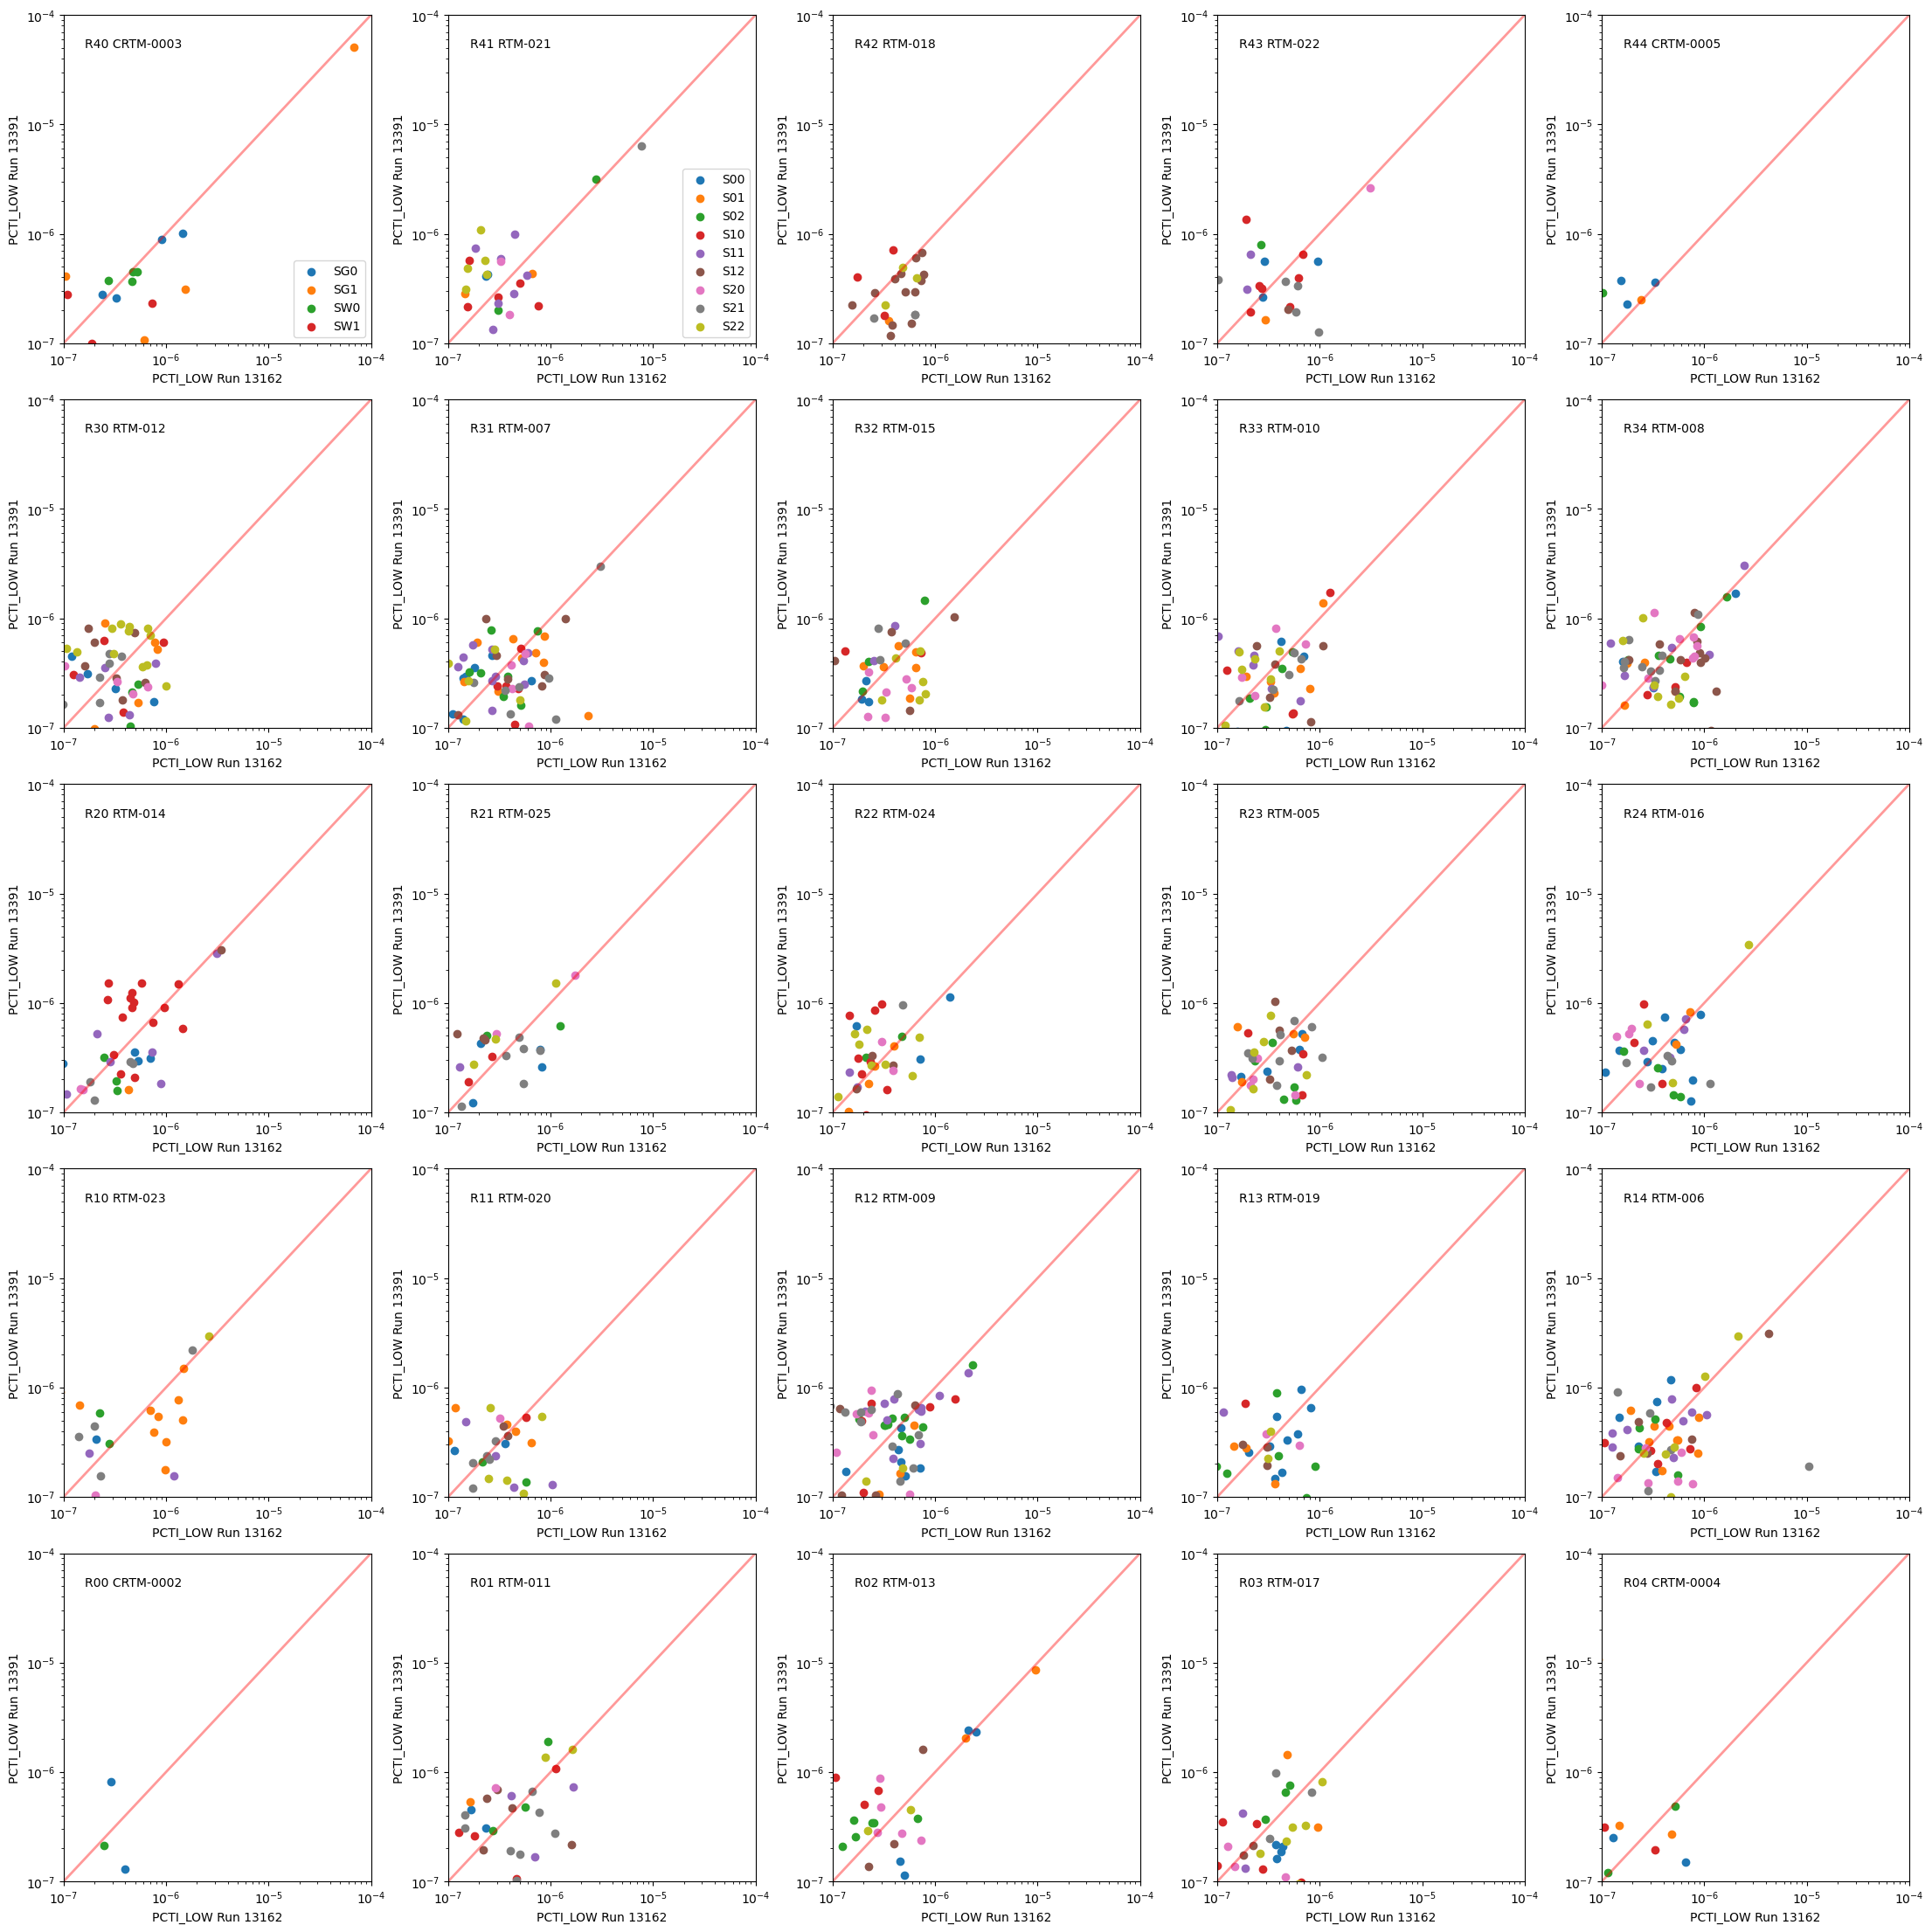

In [26]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='PCTI_LOW',minxy=1.e-7,maxxy=1.e-4,scale='log',save='pcti_low_%s'%(acq_run))

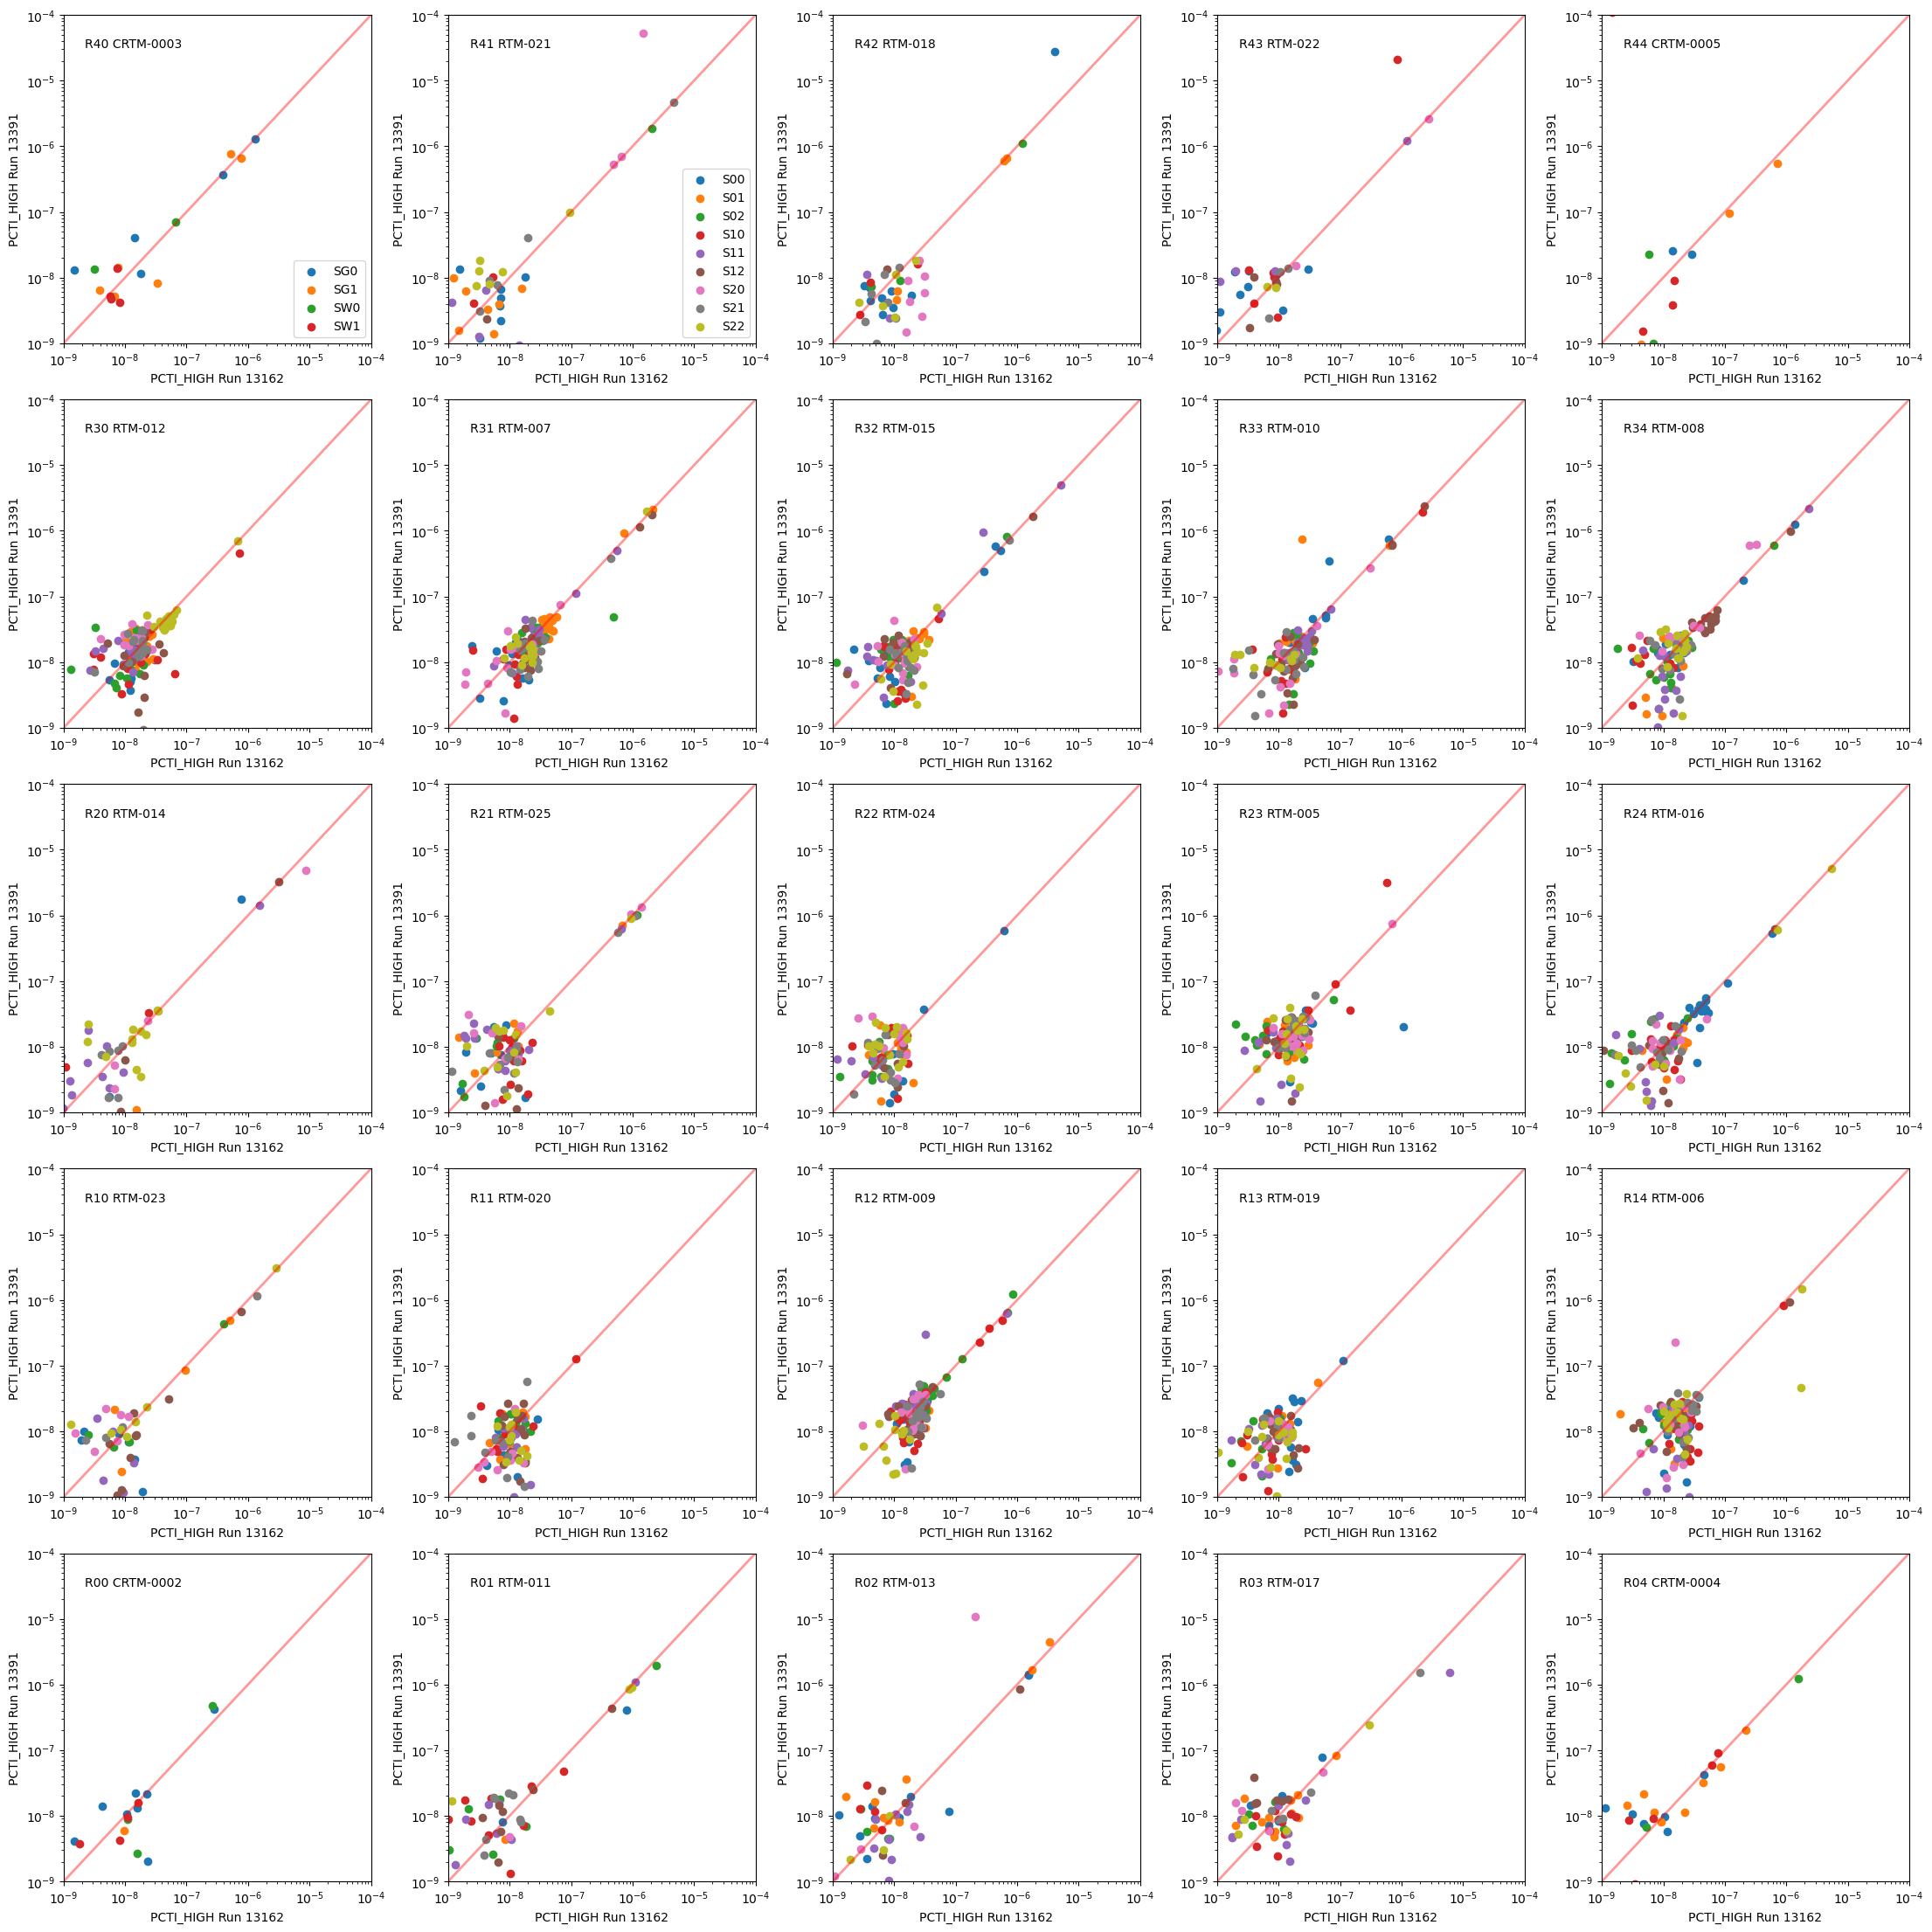

In [27]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='PCTI_HIGH',minxy=1.e-9,maxxy=1.e-4,scale='log',save='pcti_high_%s'%(acq_run))

# Divisidero

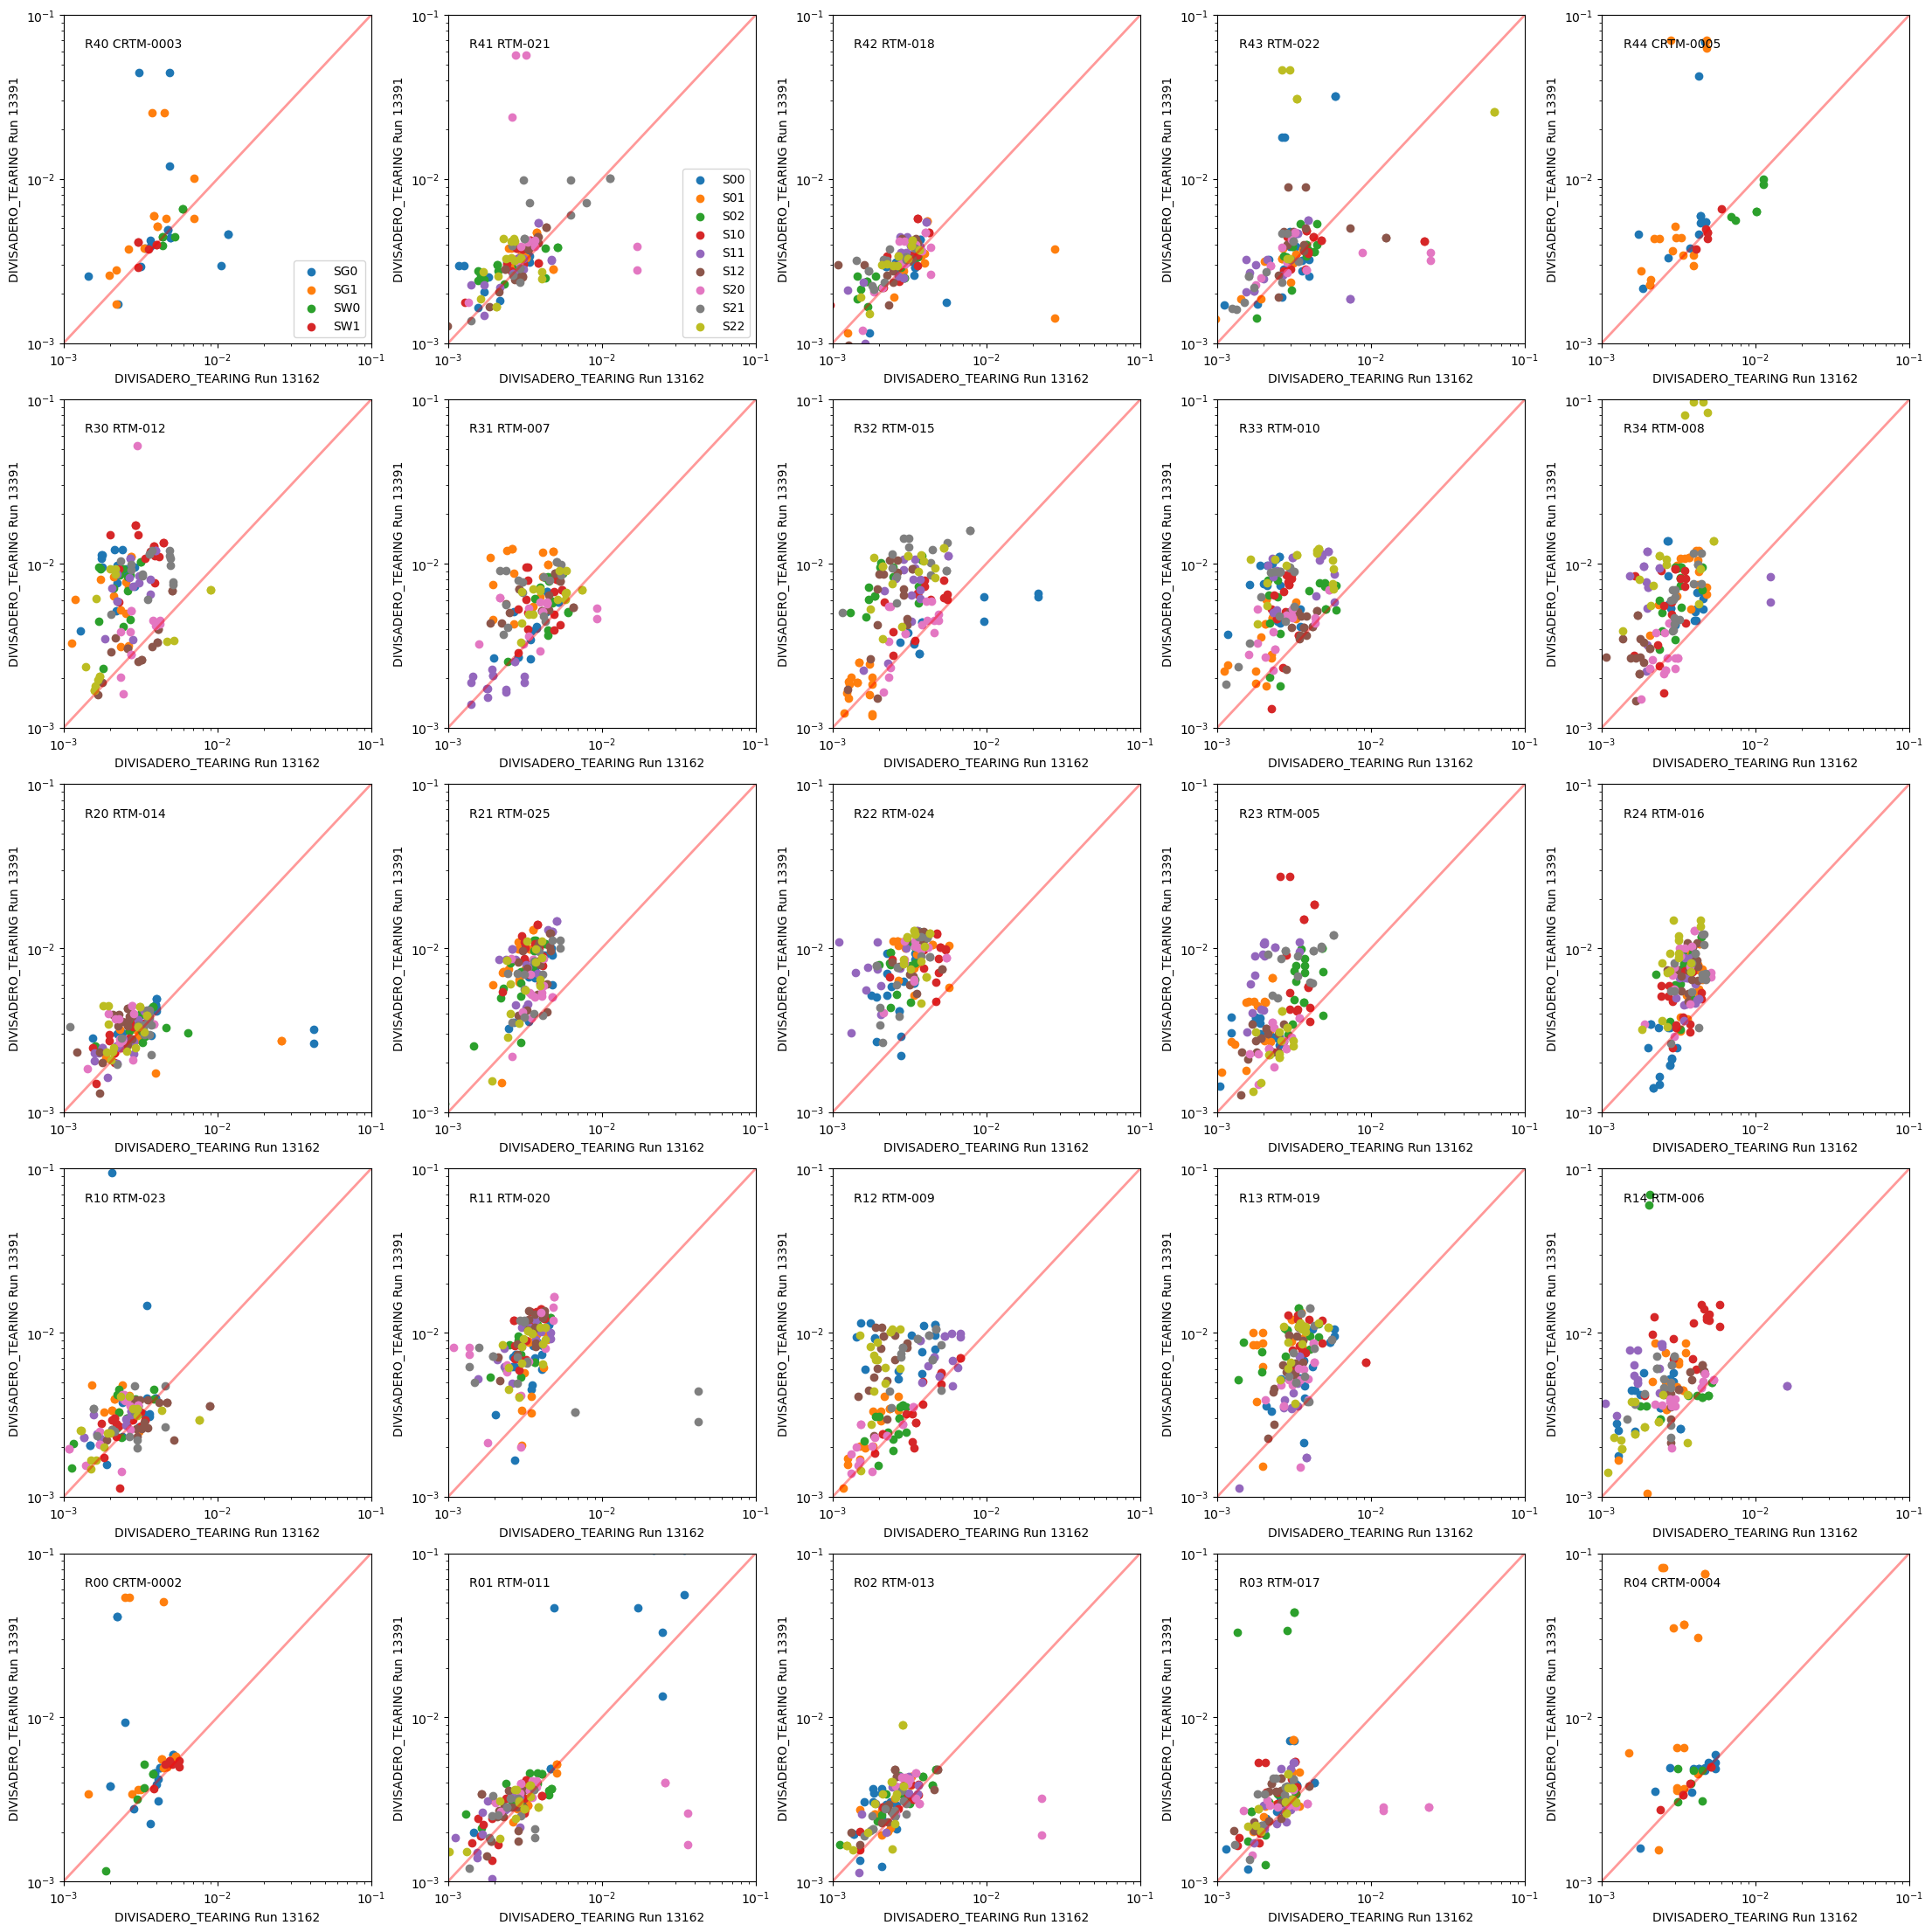

In [28]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='DIVISADERO_TEARING',minxy=1.e-3,maxxy=1.e-1,scale='log',save='divisadero_tearing_%s'%(acq_run))

# Dark Current

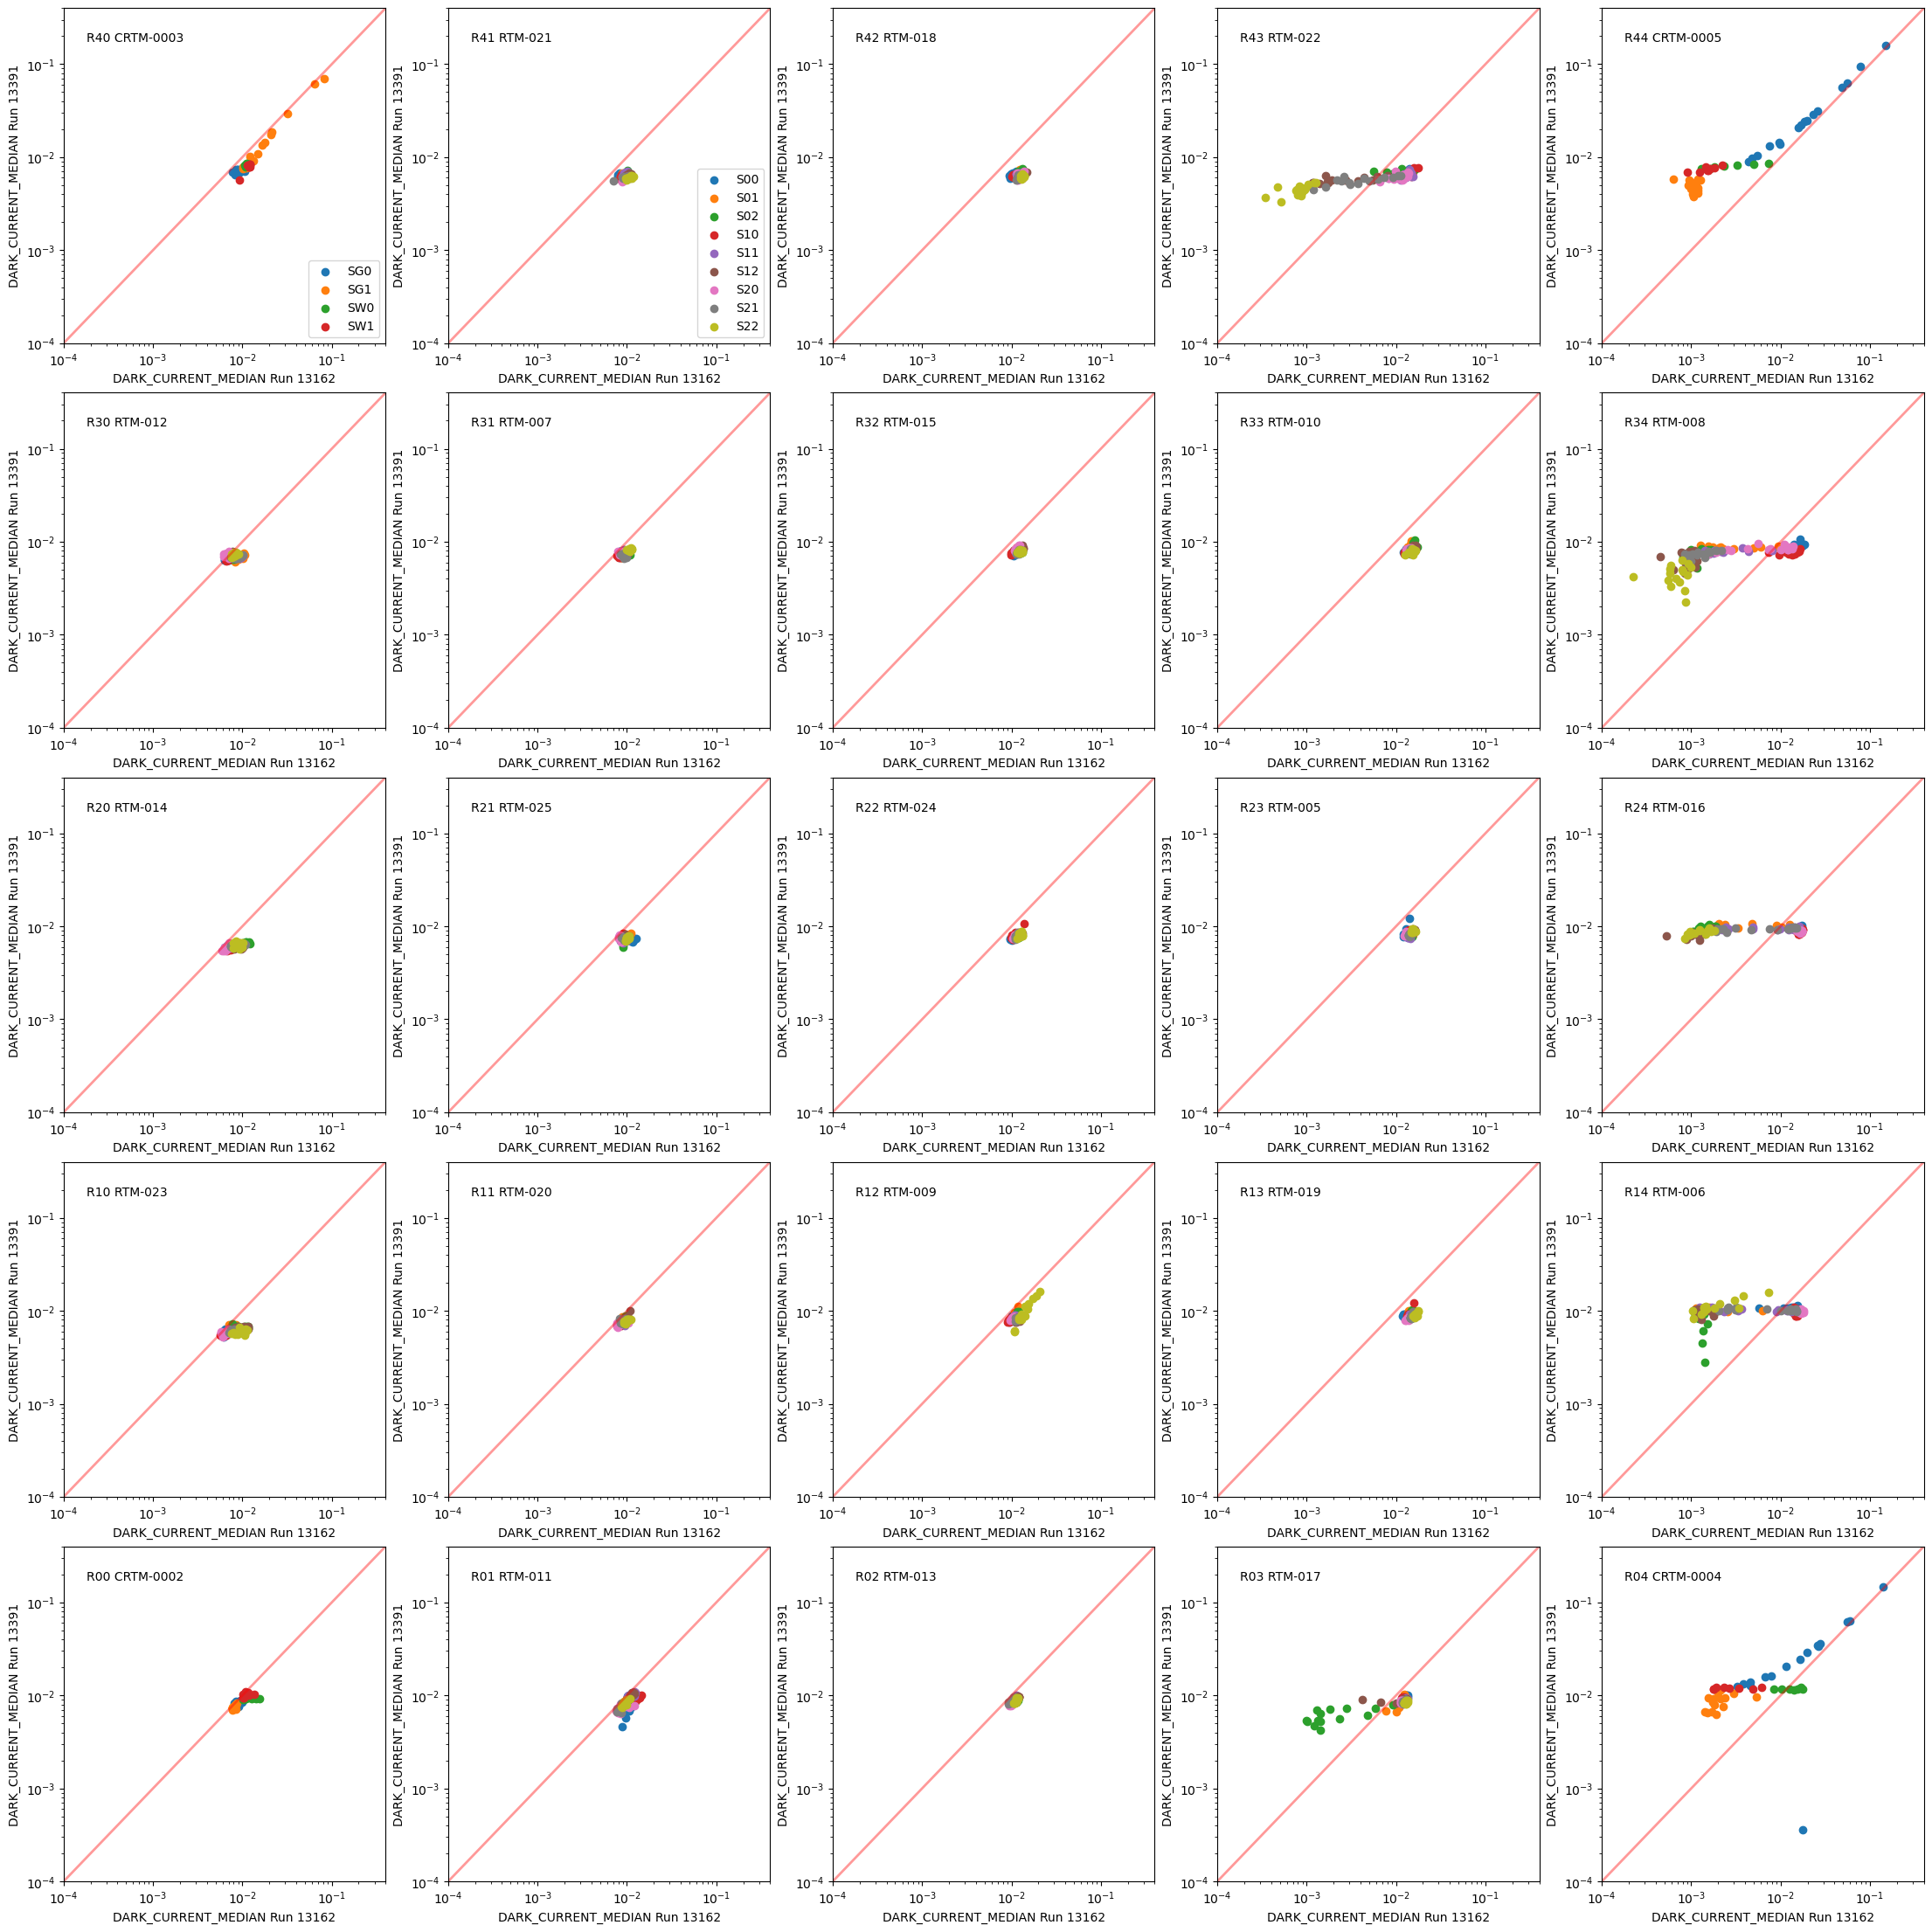

In [29]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='DARK_CURRENT_MEDIAN',minxy=1.e-4,maxxy=4.e-1,scale='log',save='darkcurrent_median_%s'%(acq_run))

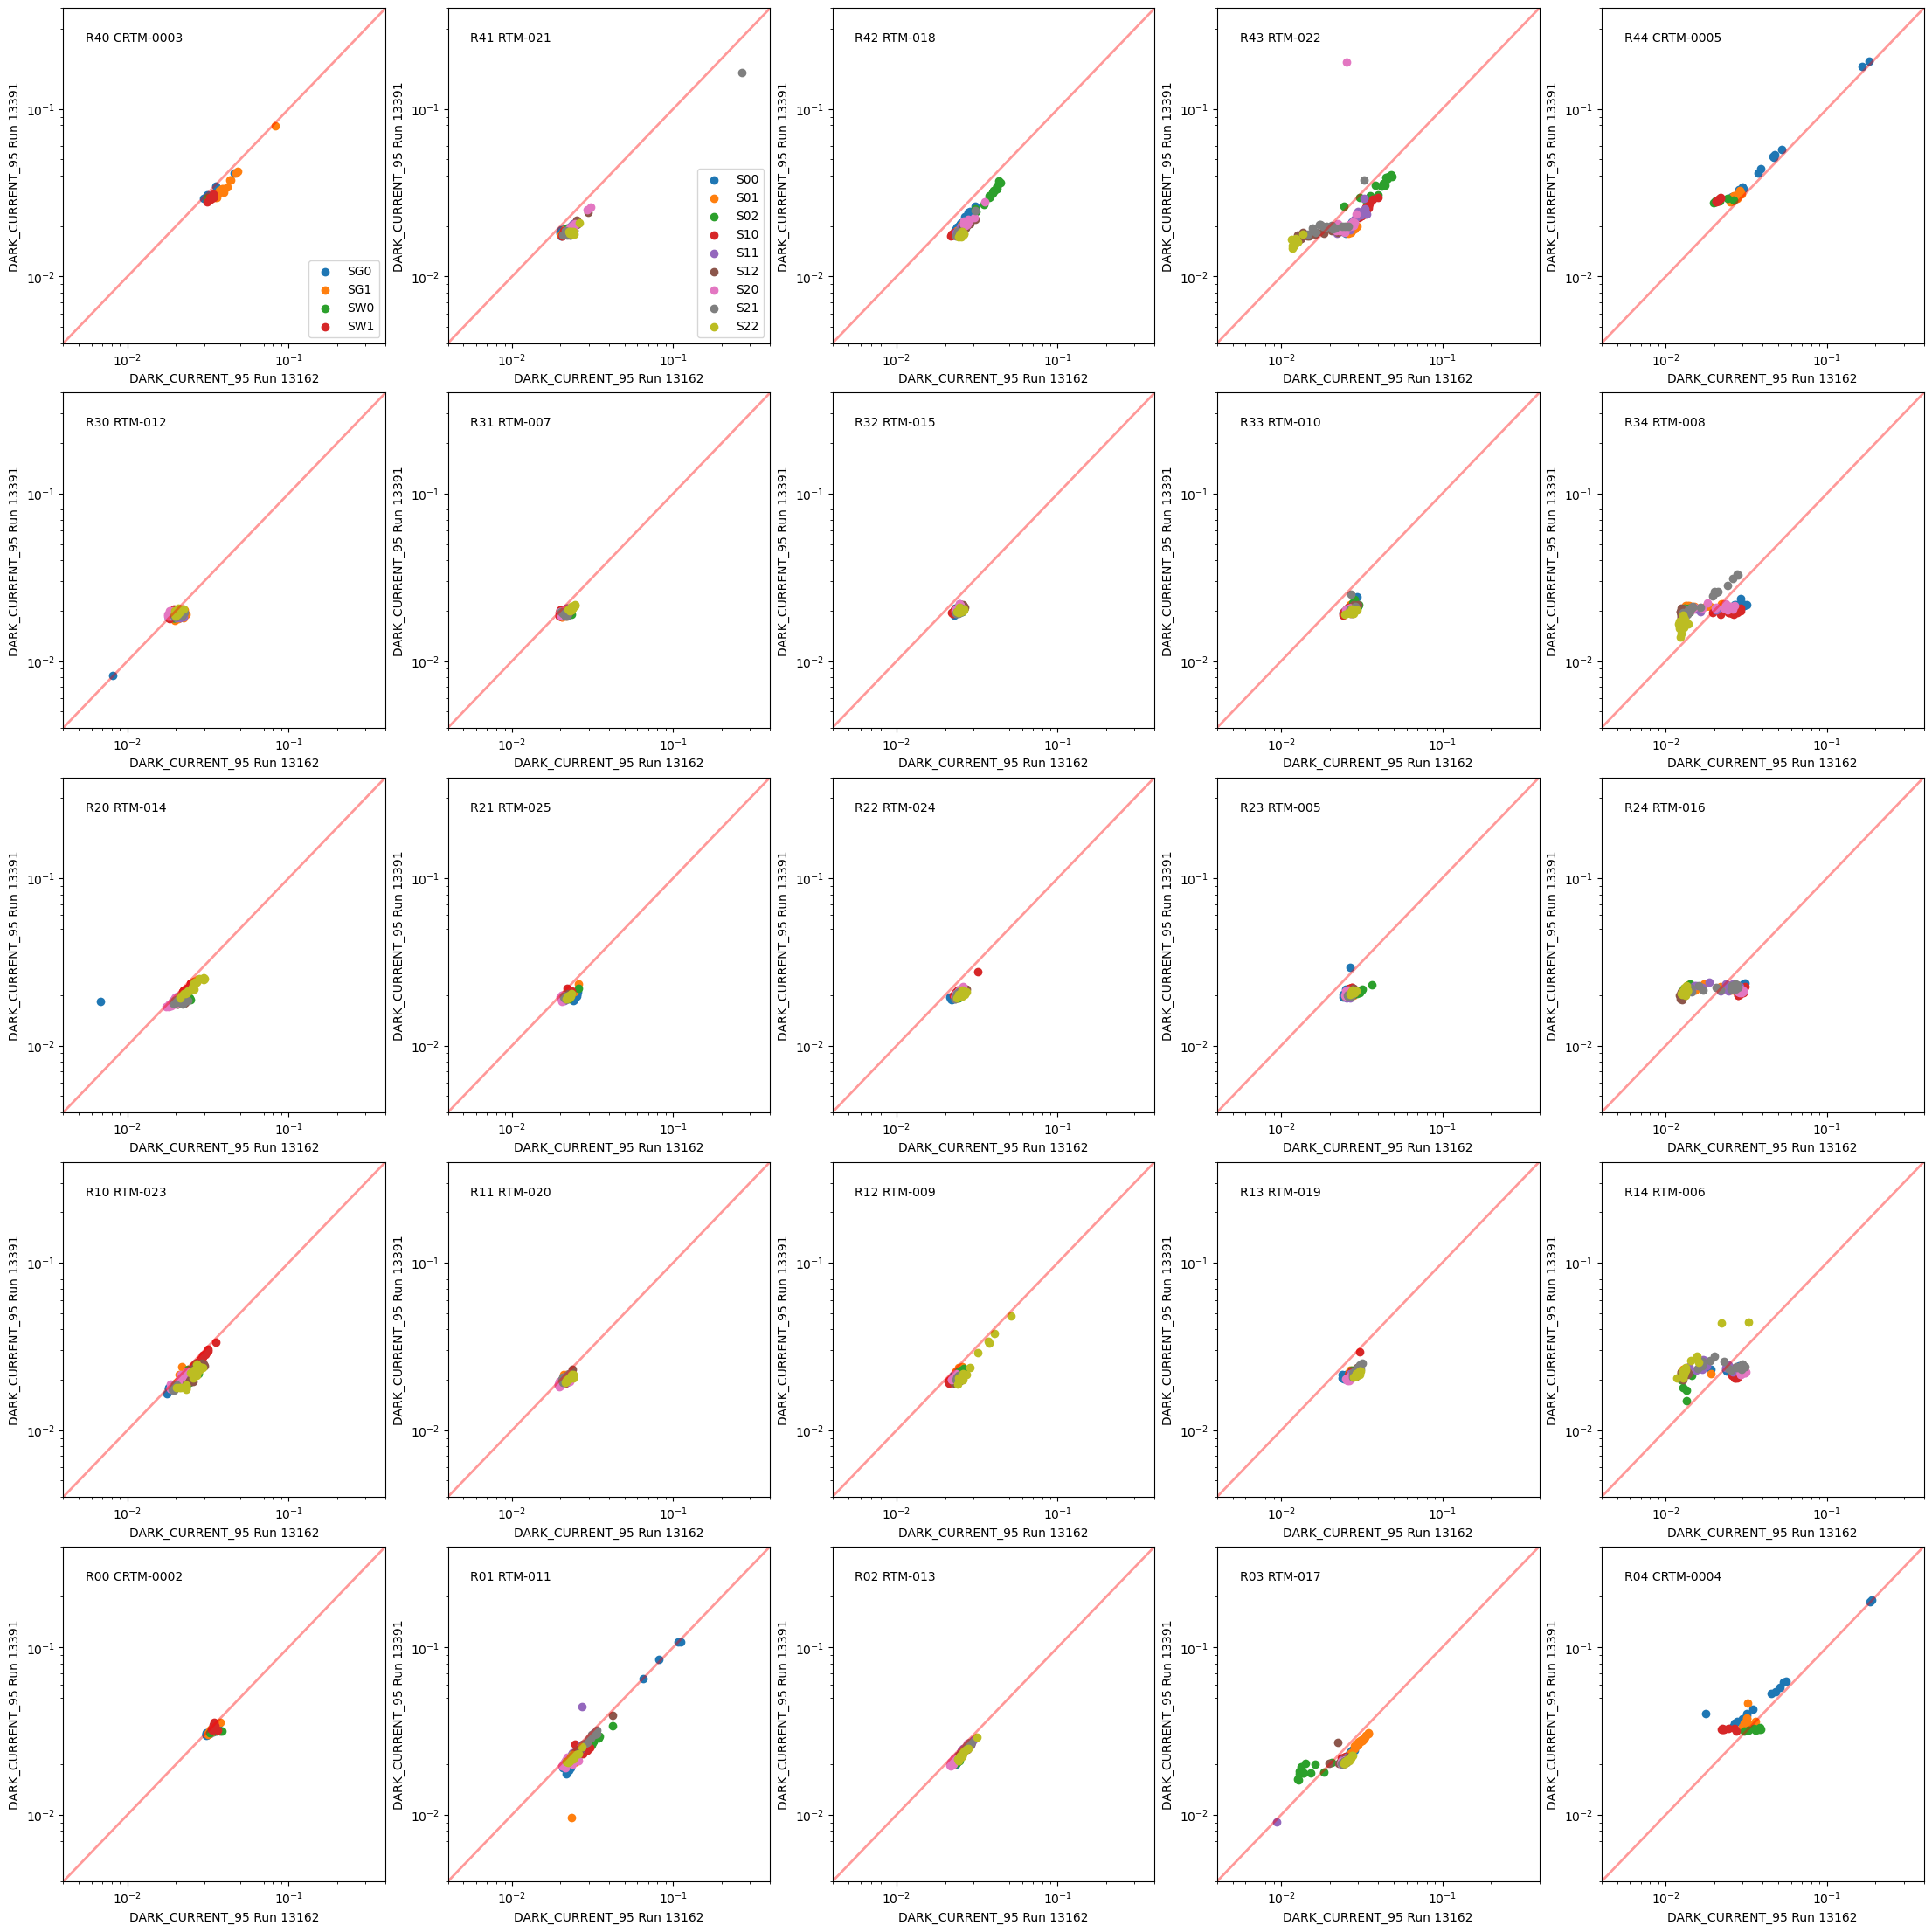

In [32]:
compare_tworuns(df_run5,df_data,'13162',acq_run,quantity='DARK_CURRENT_95',minxy=4.e-3,maxxy=4.e-1,scale='log',save='darkcurrent_95_%s'%(acq_run))

## High Dark Current channels

In [33]:
highdarkcurrent = (df_merge.DARK_CURRENT_MEDIAN>0.1)
print(tabulate(df_merge[highdarkcurrent][['BAY_SLOT','SEGMENT','DARK_CURRENT_MEDIAN','DARK_CURRENT_95','DARK_CURRENT_MEDIAN_RUN5','DARK_CURRENT_95_RUN5','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------+
|      | BAY_SLOT   | SEGMENT   |   DARK_CURRENT_MEDIAN |   DARK_CURRENT_95 |   DARK_CURRENT_MEDIAN_RUN5 |   DARK_CURRENT_95_RUN5 | COMMENT   |
|------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------|
|  482 | R04_SG0    | C12       |              0.145895 |           1.7693  |                   0.139878 |                1.77112 | Ok        |
| 3180 | R44_SG0    | C03       |              0.160347 |           1.77837 |                   0.150438 |                1.72514 | Ok        |
+------+------------+-----------+-----------------------+-------------------+----------------------------+------------------------+-----------+


## Dark Current Mosiac

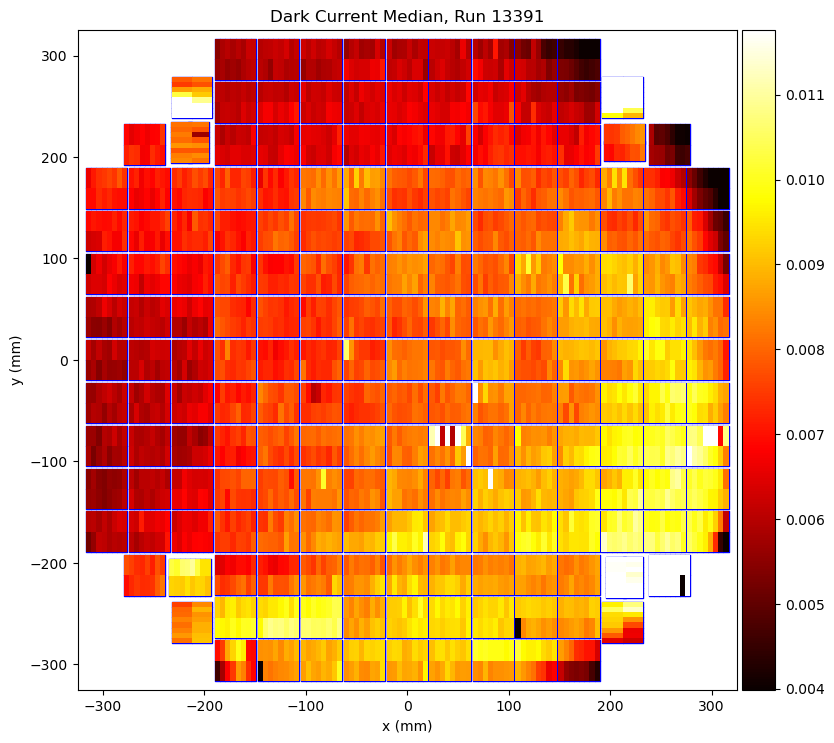

In [34]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data_13391['dark_current_median'], use_log10=False, nsigma=3, z_range='clipped_autoscale')
ax.set_title('Dark Current Median, Run %s'%(acq_run))
f.savefig('darkcurrent_median_mosaic_%s'%(acq_run))

## This pattern represents a known light leak in the Integration Stand dark box, even with the lights off in the Clean Room. Differences with Run5 are due to differences in the light leaks, not changes in intrinsic dark current

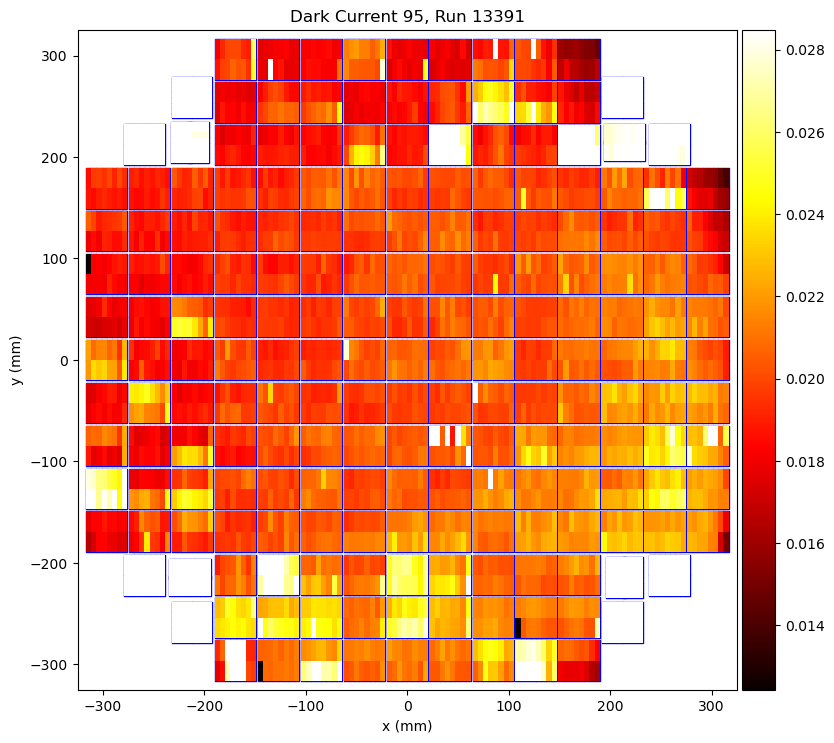

In [35]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data_13391['dark_current_95'], use_log10=False, nsigma=5, z_range='clipped_autoscale')
ax.set_title('Dark Current 95, Run %s'%(acq_run))
f.savefig('darkcurrent_95_mosaic_%s'%(acq_run))

## Run5 Dark Current Median for comparison

In [36]:
import pickle
amp_data_run5 = pickle.load(open('amp_data_13144_13162_w_2023_22.pkl','rb'))

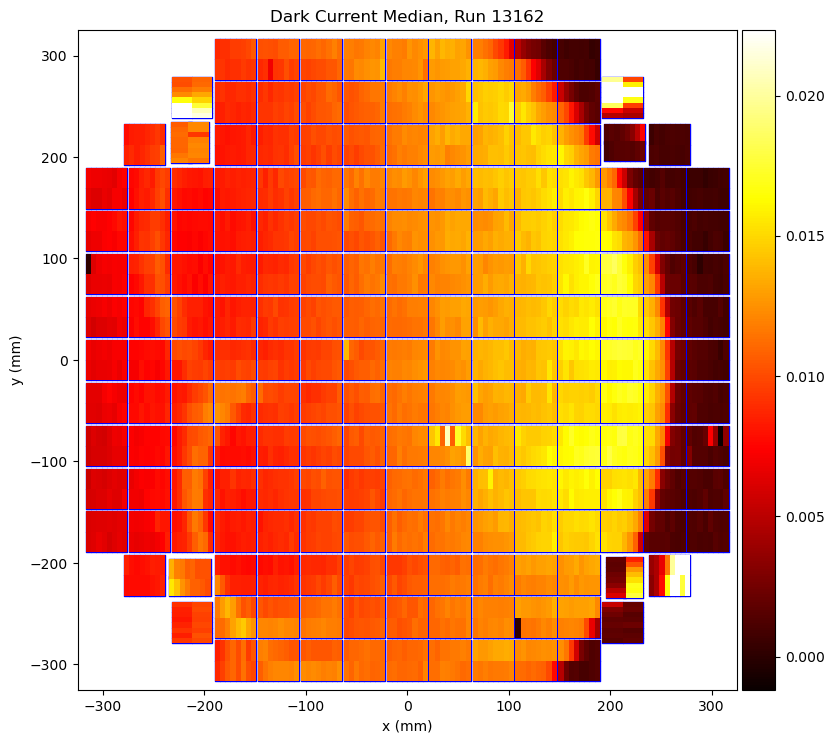

In [37]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data_run5['dark_current_median'], use_log10=False, nsigma=3, z_range='clipped_autoscale')
ax.set_title('Dark Current Median, Run %s'%('13162'))
f.savefig('darkcurrent_median_mosaic_%s'%('13162'))

# Bias Stability

In [39]:
# convert to amp_data format
def to_amp_data(df,name):
    
    outdict = {}
    for index, row in df.iterrows():
        if row.BAY_SLOT not in outdict:
            outdict[row.BAY_SLOT] = {}
            
        outdict[row.BAY_SLOT][row.SEGMENT] = row[name]
    return outdict

def get_run_biasstab(acq_run,weekly='w_2023_24',operator='lsstccs',repo='/repo/ir2',verbose=0):
    
    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)    
    butler_collections = daf_butler.Butler(repo, collections=collections)
    
    if verbose>0:
        for item in collections:
            print(item)
            
    biasstab = {}
    for i in range(205):
        biasstab[i] = butler_collections.get('bias_stability_stats',detector=i)

    if verbose>0:
        key = 98
        if key in biasstab:
            biasstab[98].columns        
            df_98 = biasstab[98]
            print(tabulate(df_98[(df_98.amp_name=='C10')],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))
            print(len(df_98[(df_98.amp_name=='C10')]))
            
    df_bias = calc_biasstability_rms(biasstab)
    
    amp_biasdata = {}
    amp_biasdata['RMS'] = to_amp_data(df_bias,'RMS')
    amp_biasdata['RC_RMS'] = to_amp_data(df_bias,'RC_RMS')
        
    return biasstab,df_bias,amp_biasdata

In [40]:
biasstab_13391,df_bias_13391,amp_biasdata_13391 = get_run_biasstab(acq_run)

In [41]:
df_98 = biasstab_13391[98]
print(tabulate(df_98[(df_98.amp_name=='C10')],headers = 'keys', tablefmt = 'psql',floatfmt='0.3f'))
print(len(df_98[(df_98.amp_name=='C10')]))

+------+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------+
|      |   run |   exposure_id |       mjd | det_name   | amp_name   |   mean |   stdev |   rc_mean |   rc_stdev |
|------+-------+---------------+-----------+------------+------------+--------+---------+-----------+------------|
|    0 | 13391 | 3023062100292 | 60117.011 | R22_S22    | C10        |  0.126 |   3.636 |     0.295 |      3.686 |
|   16 | 13391 | 3023062100343 | 60117.044 | R22_S22    | C10        |  0.145 |   3.612 |     0.276 |      3.607 |
|   32 | 13391 | 3023062100269 | 60117.004 | R22_S22    | C10        |  0.250 |   3.646 |     0.384 |      3.673 |
|   48 | 13391 | 3023062100446 | 60117.062 | R22_S22    | C10        |  0.206 |   3.577 |     0.427 |      3.582 |
|   64 | 13391 | 3023062100449 | 60117.062 | R22_S22    | C10        |  0.127 |   3.545 |     0.334 |      3.561 |
|   80 | 13391 | 3023062100325 | 60117.041 | R22_S22    | C10        |  0.233 | 

## Calculate bias stability RMS for all and rc

In [42]:
df_bias = df_bias_13391

In [43]:
e2v = (df_bias.TYPE=='e2v')
itl = (df_bias.TYPE=='itl') 
corner = (df_bias.TYPE=='corner')

In [44]:
print(df_bias)

     BAY_SLOT    TYPE SEGMENT       RMS       RC_RMS
0     R01_S00     itl     C10  0.180080     0.276496
1     R01_S00     itl     C11  0.033320     0.134056
2     R01_S00     itl     C12  0.040750     0.374830
3     R01_S00     itl     C13  0.156439     1.875535
4     R01_S00     itl     C14  0.140852  3728.807874
...       ...     ...     ...       ...          ...
3211  R44_SW1  corner     C13  0.039679     0.097248
3212  R44_SW1  corner     C14  0.052031     0.095869
3213  R44_SW1  corner     C15  0.040495     0.080960
3214  R44_SW1  corner     C16  0.052592     0.132080
3215  R44_SW1  corner     C17  0.569893     0.599557

[3216 rows x 5 columns]


Text(0.5, 0.98, 'Run 13391')

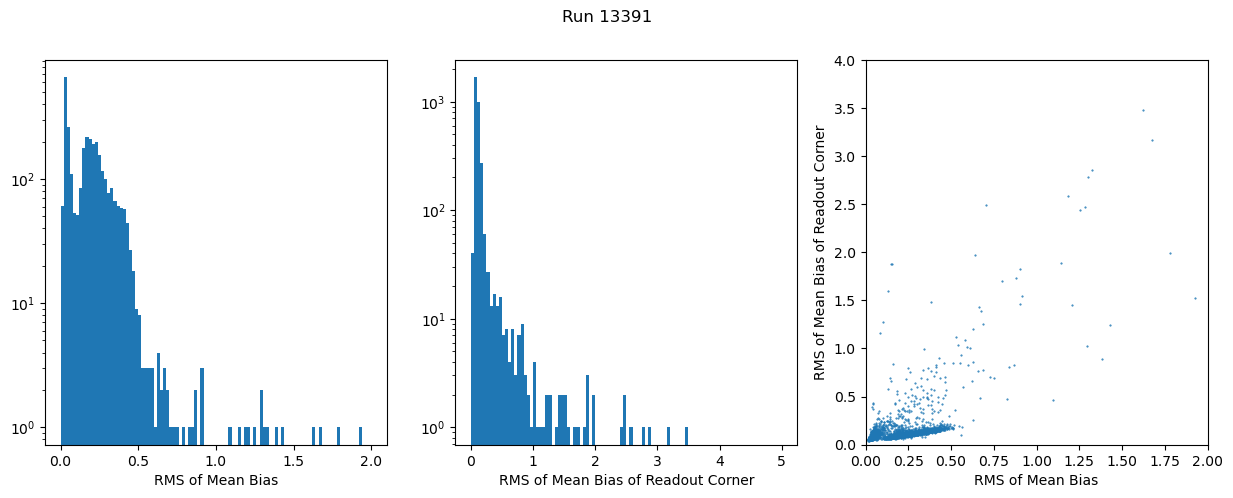

In [45]:
f,ax = plt.subplots(1,3,figsize=(15,5))
h = ax[0].hist(df_bias.RMS,bins=100,range=(0.,2.))
ax[0].set_xlabel('RMS of Mean Bias')
ax[0].set_yscale('log')

h = ax[1].hist(df_bias.RC_RMS,bins=100,range=(0.,5.))
ax[1].set_xlabel('RMS of Mean Bias of Readout Corner')
ax[1].set_yscale('log')

h = ax[2].scatter(df_bias.RMS,df_bias.RC_RMS,marker='.',s=1.)
ax[2].set_ylim(0.,4.)
ax[2].set_xlim(0.,2.)
ax[2].set_xlabel('RMS of Mean Bias')
ax[2].set_ylabel('RMS of Mean Bias of Readout Corner')
f.suptitle('Run %s'%(acq_run))

Text(0.5, 1.0, 'RMS of Mean Bias, Run 13391')

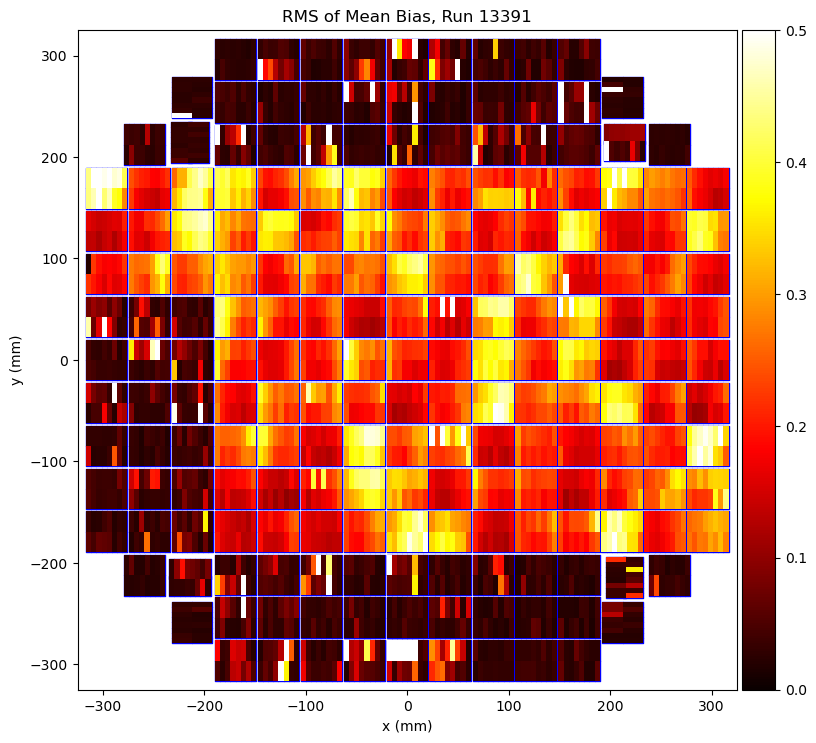

In [47]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_biasdata_13391['RMS'], z_range=(0, 0.5))
ax.set_title('RMS of Mean Bias, Run %s'%(acq_run))

Text(0.5, 1.0, 'RMS of Mean Bias in Readout Corner, Run 13391')

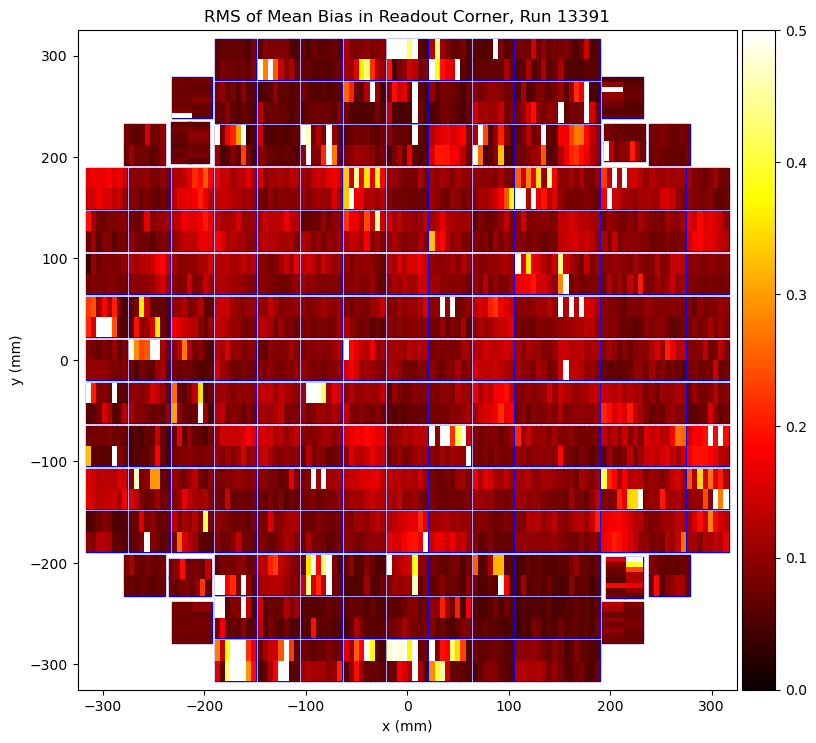

In [48]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_biasdata_13391['RC_RMS'], z_range=(0, 0.5))
ax.set_title('RMS of Mean Bias in Readout Corner, Run %s'%(acq_run))

# Get Run 13162 (Run5) Bias stability data

In [57]:
biasstab_sp_13162 = pickle.load(open('biasstab_sp_13162.pkl','rb'))
biasstab_s_13162 = pickle.load(open('biasstab_s_13162.pkl','rb'))

In [50]:
df_bias_13162 = pd.read_parquet('df_13162_biasstab.parquet')
print(df_bias_13162.columns)

Index(['BAY_SLOT', 'TYPE', 'SEGMENT', 'RMS_S', 'RC_RMS_S', 'RMS_SP',
       'RC_RMS_SP'],
      dtype='object')


In [53]:
amp_biasdata_run5 = pickle.load(open('amp_biasdata_13162.pkl','rb'))
print(amp_biasdata_run5.keys())

# _SP means serial+parallel overscan, _S is just serial overscan

dict_keys(['RMS_SP', 'RC_RMS_SP', 'RMS_S', 'RC_RMS_S'])


Text(0.5, 0.98, 'Run 13162')

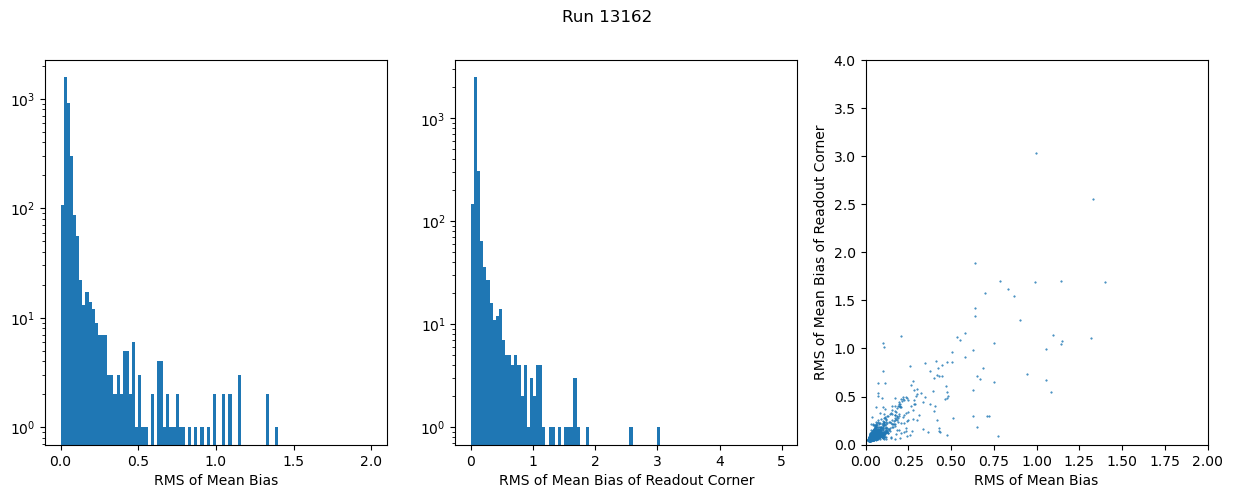

In [74]:
f,ax = plt.subplots(1,3,figsize=(15,5))
h = ax[0].hist(df_bias_13162.RMS_S,bins=100,range=(0.,2.))
ax[0].set_xlabel('RMS of Mean Bias')
ax[0].set_yscale('log')

h = ax[1].hist(df_bias_13162.RC_RMS_S,bins=100,range=(0.,5.))
ax[1].set_xlabel('RMS of Mean Bias of Readout Corner')
ax[1].set_yscale('log')

h = ax[2].scatter(df_bias_13162.RMS_S,df_bias_13162.RC_RMS_S,marker='.',s=1.)
ax[2].set_ylim(0.,4.)
ax[2].set_xlim(0.,2.)
ax[2].set_xlabel('RMS of Mean Bias')
ax[2].set_ylabel('RMS of Mean Bias of Readout Corner')
f.suptitle('Run %s'%('13162'))

Text(0.5, 1.0, 'RMS of Mean Bias, Run 13162')

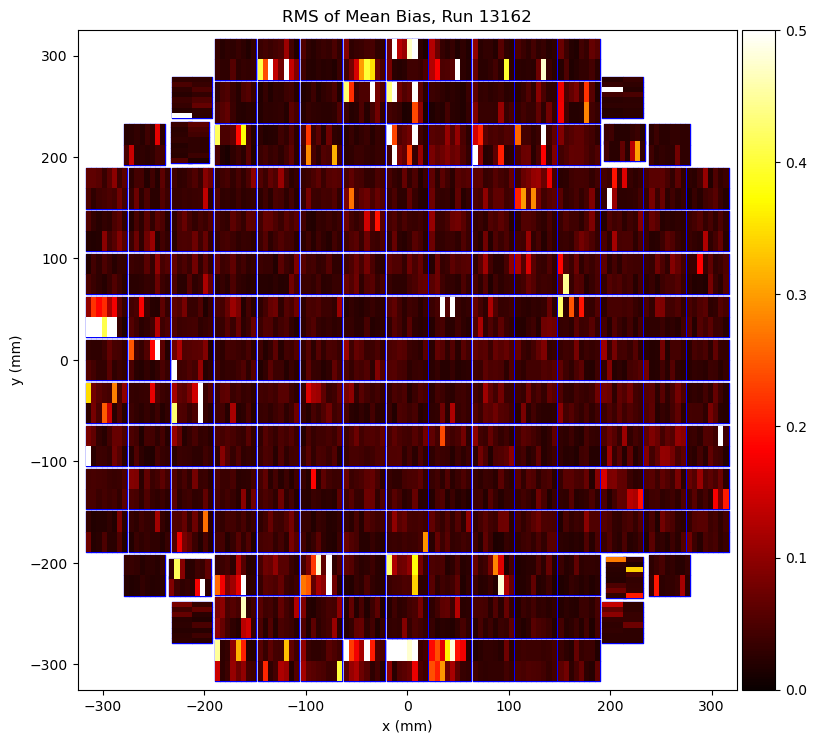

In [64]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_biasdata_run5['RMS_S'], z_range=(0, 0.5))
ax.set_title('RMS of Mean Bias, Run %s'%('13162'))

Text(0.5, 1.0, 'RMS of Mean Bias in Readout Corner, Run 13162')

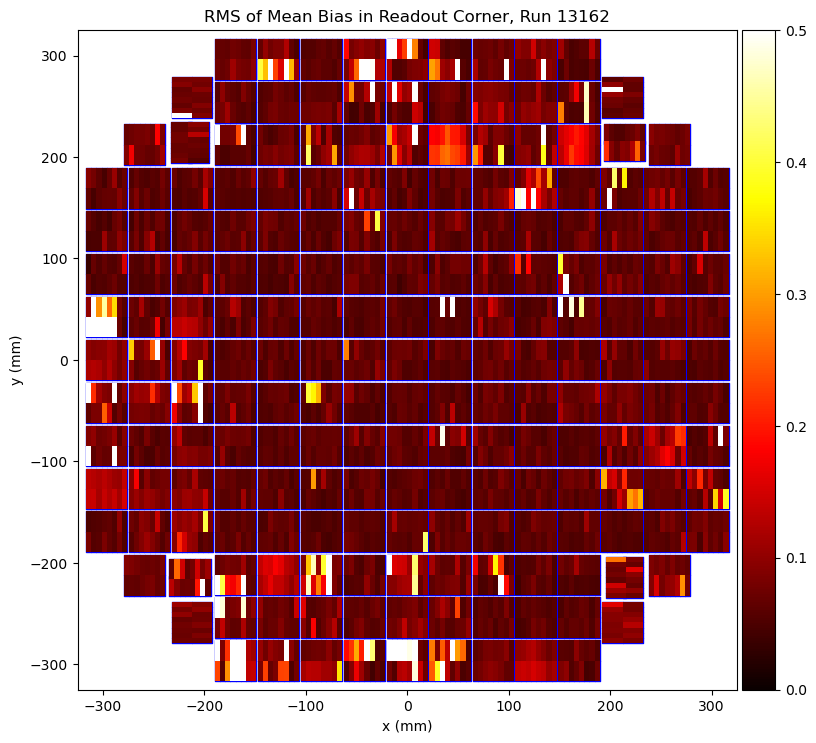

In [73]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_biasdata_run5['RC_RMS_S'], z_range=(0, 0.5))
ax.set_title('RMS of Mean Bias in Readout Corner, Run %s'%('13162'))

## Compare some individual channels for Mean Bias vs. MJD

In [66]:
def plot_biasstability(idet,biasstab_1,biasstab_2,title1,title2,var='mean'):
 
    det_name = det_names[idet]
    f,ax = plt.subplots(1,2,figsize=(12,6))

    df_det_1 = biasstab_1[idet]
    df_det_2 = biasstab_2[idet]

    minmjd = np.min(df_det_1['mjd'])
    for i,seg in enumerate(segments):
        df_C = df_det_1[(df_det_1.amp_name==seg)]
        marker = 'o' if i < 8 else 's'
        h = ax[0].scatter(24.*60.*(df_C['mjd']-minmjd),df_C[var],marker=marker,label=seg)
    
    ax[0].set_xlabel('Minutes')
    ax[0].set_ylabel('Bias '+var)
    ax[0].set_title(title1)

    minmjd = np.min(df_det_2['mjd'])
    for i,seg in enumerate(segments):
        df_C = df_det_2[(df_det_2.amp_name==seg)]
        marker = 'o' if i < 8 else 's'
        h = ax[1].scatter(24.*60.*(df_C['mjd']-minmjd),df_C[var],marker=marker)
    
    ax[1].set_xlabel('Minutes')
    ax[1].set_ylabel('Bias '+var)
    ax[1].set_title(title2)

    f.suptitle('%s, Detector %d'%(det_name,idet))

    f.legend() 

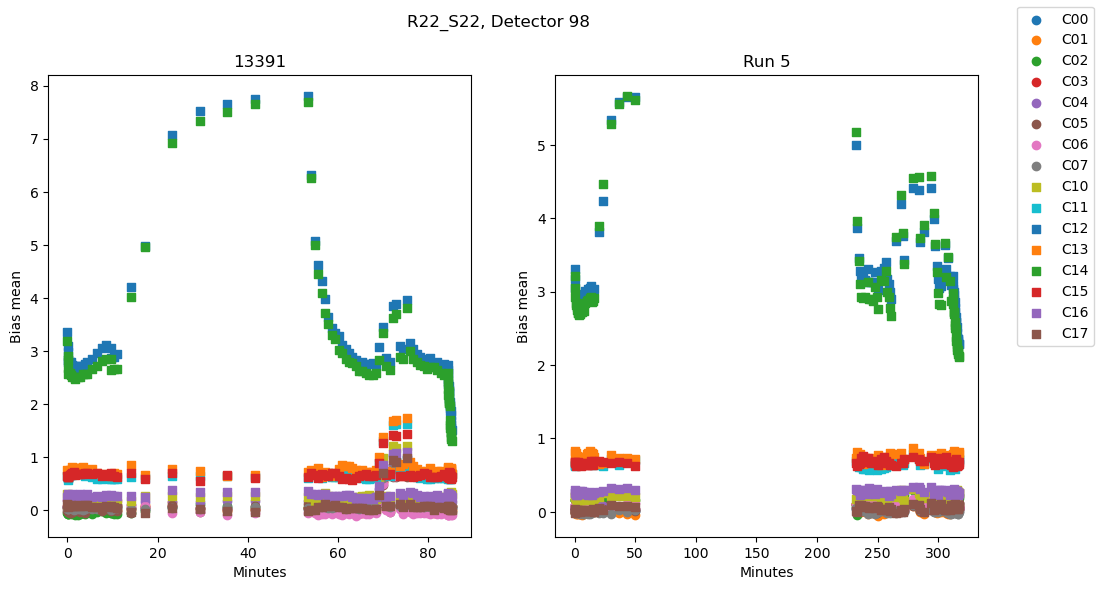

In [67]:
plot_biasstability(98,biasstab_13391,biasstab_s_13162,acq_run,'Run 5')

## R22_S22 shows some movement of the bias following the highest flux FLAT pairs in the PTC section

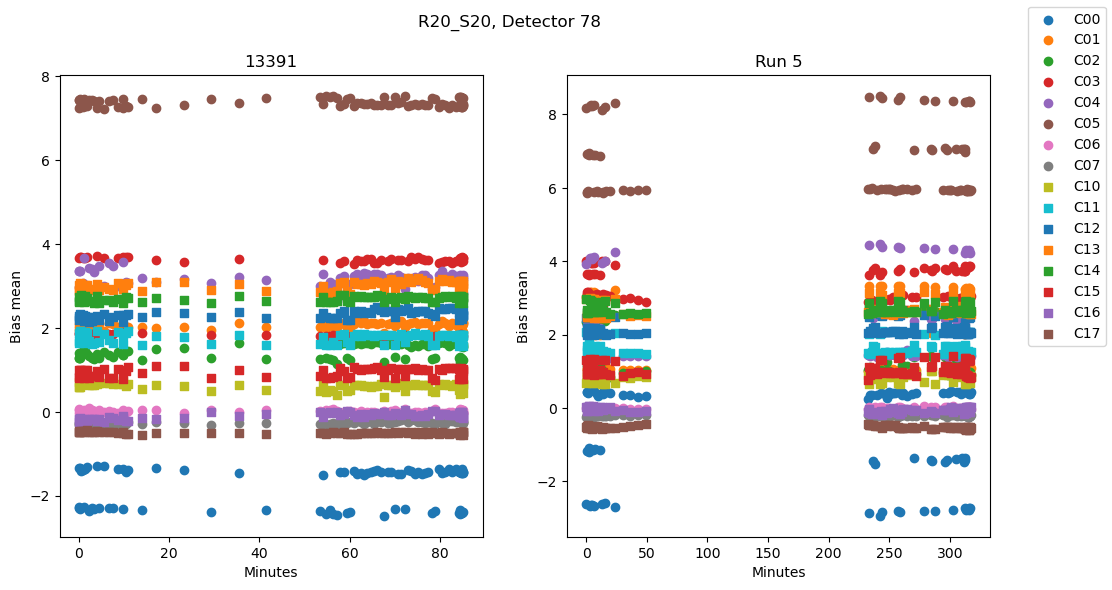

In [69]:
plot_biasstability(78,biasstab_13391,biasstab_s_13162,acq_run,'Run 5')

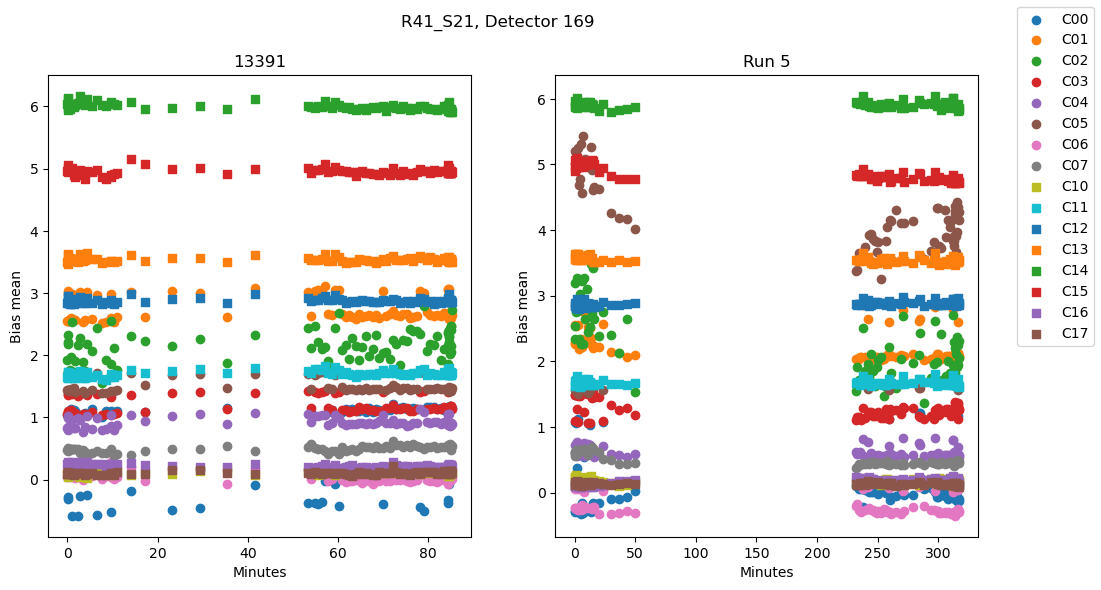

In [70]:
plot_biasstability(169,biasstab_13391,biasstab_s_13162,acq_run,'Run 5')

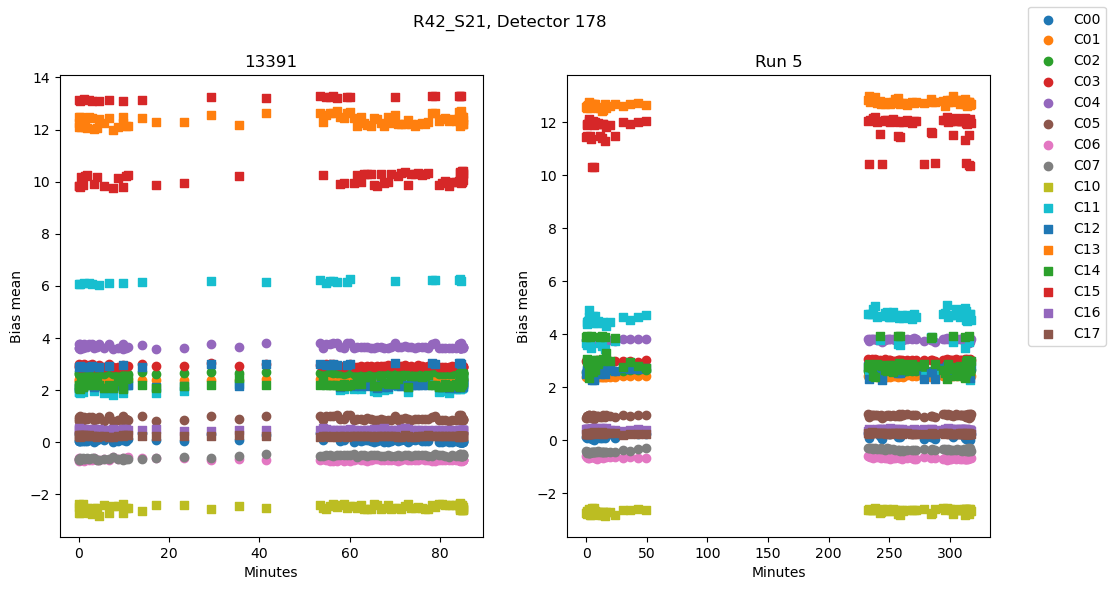

In [71]:
plot_biasstability(178,biasstab_13391,biasstab_s_13162,acq_run,'Run 5')

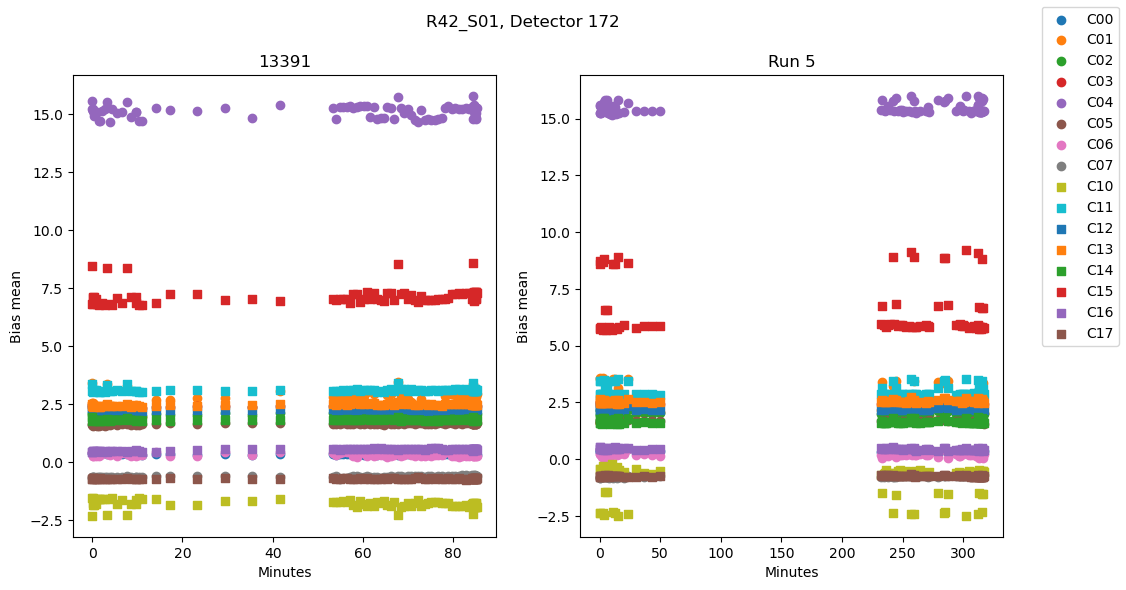

In [72]:
plot_biasstability(172,biasstab_13391,biasstab_s_13162,acq_run,'Run 5')

# compare RMS and RC_RMS Run 13391 vs. Run5

In [76]:
df_bias_merge = df_bias_13391.merge(df_bias_13162,how='outer',on=['BAY_SLOT','SEGMENT','TYPE'],suffixes=('','_RUN5'))
print(df_bias_merge.columns)

Index(['BAY_SLOT', 'TYPE', 'SEGMENT', 'RMS', 'RC_RMS', 'RMS_S', 'RC_RMS_S',
       'RMS_SP', 'RC_RMS_SP'],
      dtype='object')


## 'RMS' and 'RC_RMS' are RUn 13391, other variables are from Run5

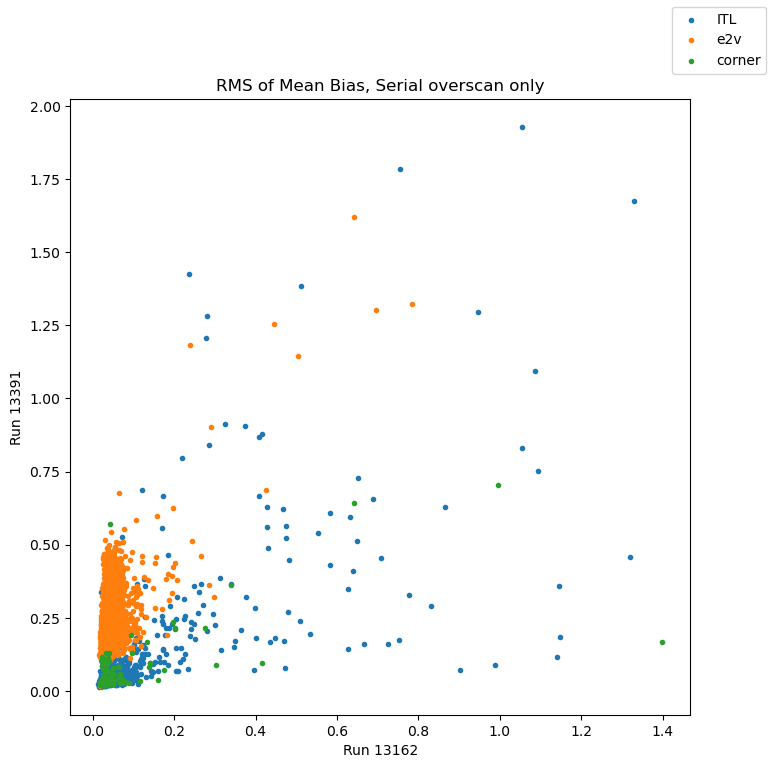

In [80]:
f,ax = plt.subplots(1,1,figsize=(8,8))
h = ax.scatter(df_bias_merge[itl]['RMS_S'],df_bias_merge[itl]['RMS'],marker='.',label='ITL')
h = ax.scatter(df_bias_merge[e2v]['RMS_S'],df_bias_merge[e2v]['RMS'],marker='.',label='e2v')
h = ax.scatter(df_bias_merge[corner]['RMS_S'],df_bias_merge[corner]['RMS'],marker='.',label='corner')

ax.set_xlabel('Run 13162')
ax.set_ylabel('Run 13391')
ax.set_title('RMS of Mean Bias, Serial overscan only')
f.legend()

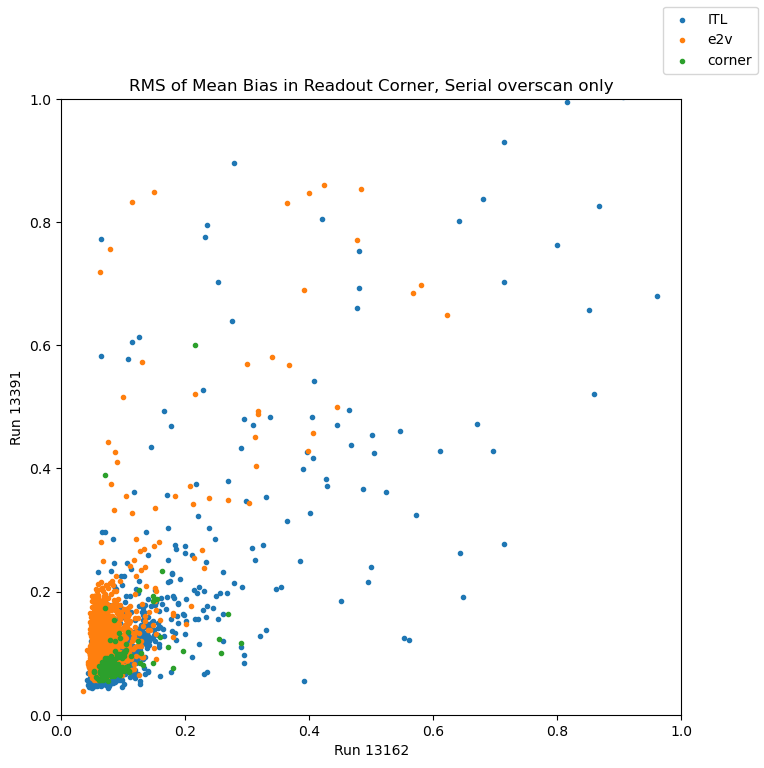

In [82]:
f,ax = plt.subplots(1,1,figsize=(8,8))
h = ax.scatter(df_bias_merge[itl]['RC_RMS_S'],df_bias_merge[itl]['RC_RMS'],marker='.',label='ITL')
h = ax.scatter(df_bias_merge[e2v]['RC_RMS_S'],df_bias_merge[e2v]['RC_RMS'],marker='.',label='e2v')
h = ax.scatter(df_bias_merge[corner]['RC_RMS_S'],df_bias_merge[corner]['RC_RMS'],marker='.',label='corner')

ax.set_xlabel('Run 13162')
ax.set_ylabel('Run 13391')
ax.set_title('RMS of Mean Bias in Readout Corner, Serial overscan only')
ax.set_ylim(0.,1.0)
ax.set_xlim(0.,1.0)
f.legend()